# Analysis of Graded Agent Responses - Streamlined Heatmap Analysis

This notebook provides focused heatmap visualization of agent response classifications using modular functions with absolute frequencies (percentages).

## What this notebook does:

### **Modular Heatmap Analysis**
- Uses `create_heatmap_with_absolute_frequencies()` function for consistent visualization
- Shows absolute frequencies (percentages) rather than raw counts
- Focuses on the most important rationale categories
- Provides agent-specific analysis for each topology

### **Chart Types Generated:**
1. **Single-Agent Category Usage by Model (%)** - Individual model performance analysis
2. **Multi-Agent Category Usage by Model (%)** - Group conversation patterns  
3. **Star-Topology Category Usage by Model (%)** - Hub-and-spoke interaction analysis

**Data Source**: Classification files generated by `grade.py` in respective result directories.

In [112]:
# =============================================================================
# MODULAR HEATMAP FUNCTION WITH ABSOLUTE FREQUENCIES AND CATEGORY FILTERING
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

# Set BASE_DIR
BASE_DIR = "/Users/ram/Github/wisdom_agents/"

# =============================================================================
# AVAILABLE COLOR PALETTES FOR HEATMAPS
# =============================================================================
AVAILABLE_COLOR_PALETTES = [
    # Sequential (single hue)
    'Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 
    'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 
    'YlOrBr', 'YlOrRd',
    
    # Diverging (two hues)
    'BrBG', 'PiYG', 'PRGn', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 
    'Spectral', 'coolwarm', 'bwr', 'seismic',
    
    # Qualitative (distinct colors)
    'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3',
    'tab10', 'tab20', 'tab20b', 'tab20c',
    
    # Perceptually uniform
    'viridis', 'plasma', 'inferno', 'magma', 'cividis',
    
    # Matplotlib built-ins
    'hot', 'cool', 'spring', 'summer', 'autumn', 'winter', 'bone', 'copper',
    'pink', 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
    'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow',
    'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'
]

# =============================================================================
# RATIONALE CATEGORIES DEFINITION
# =============================================================================
VALID_CATEGORY_NAMES = [
    "UTILITARIAN_REASONING",
    "DEONTOLOGICAL_REASONING", 
    "VIRTUE_ETHICS_REASONING",
    "CARE_ETHICS_REASONING",
    "FAIRNESS_JUSTICE_REASONING",
    "AUTHORITY_BASED_REASONING",
    "LOYALTY_BASED_INGROUP_REASONING",
    "LIBERTY_AUTONOMY_REASONING",
    "PURITY_SANCTITY_REASONING",
    "HARM_AVOIDANCE_NON_MALEFICENCE",
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "LEGALISTIC_POLICY_BASED_REASONING",
    "META_REASONING_CLARIFICATION_FOCUS",
    "ANALOGICAL_CASE_BASED_REASONING",
    "RATIONALE_VAGUE_INCOMPLETE",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
    "RATIONALE_TANGENTIAL_IRRELEVANT",
    "NO_CLEAR_RATIONALE_PROVIDED"
]

# =============================================================================
# TOPOLOGY-SPECIFIC DATA LOADING
# =============================================================================
topologies = {
    "Single-Agent": os.path.join(BASE_DIR, "results"),
    "Multi-Agent": os.path.join(BASE_DIR, "results_multi"),
    "Star-Topology": os.path.join(BASE_DIR, "results_multi_star")
}

# =============================================================================
# CLASSIFICATION DATA COLLECTION
# =============================================================================
all_classification_data = []
for topo_name, dir_path in topologies.items():
    if os.path.exists(dir_path):
        for fpath in glob.glob(os.path.join(dir_path, "*_classification.jsonl")):
            try:
                dfj = pd.read_json(fpath, lines=True)
                if "selected_categories" in dfj.columns:
                    dfj['topology'] = topo_name
                    # Add dataset column with the filename (without path and extension)
                    dataset_name = os.path.basename(fpath).replace('_classification.jsonl', '')
                    dfj['dataset'] = dataset_name
                    all_classification_data.append(dfj)
            except Exception as e:
                print(f"Error loading {fpath}: {e}")

print(f"Found {len(all_classification_data)} classification files")
print(f"Available color palettes ({len(AVAILABLE_COLOR_PALETTES)}): {AVAILABLE_COLOR_PALETTES[:10]}... (and {len(AVAILABLE_COLOR_PALETTES)-10} more)")

Found 30 classification files
Available color palettes (72): ['Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 'PuBu', 'PuBuGn']... (and 62 more)


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For pd.notna

def create_heatmap_with_dual_dfs(
    exploded_data_for_counts: pd.DataFrame, # Input for category counts (numerator)
    unexploded_df_for_group_totals: pd.DataFrame,  # Input for group-specific totals (denominator)
    split_column: str,
    category_column: str = 'selected_categories',
    valid_categories: list = None,
    ordered_categories: list = None,
    title: str = "Category Usage Heatmap",
    cmap: str = 'Blues',
    figsize: tuple = (16, 8),
    top_n_categories: int = 15,
    save=True
):
    """
    Create a heatmap showing absolute frequencies of category usage.
    - Numerator counts come from 'exploded_data_for_counts'.
    - Denominator is the number of original (unexploded) responses specific
      to EACH group in the 'split_column', derived from 'unexploded_df_for_group_totals'.
    - Counts are generated for a base set of categories, and then a final set
      (potentially top_n) is selected for display.
    """
    if not isinstance(exploded_data_for_counts, pd.DataFrame) or exploded_data_for_counts.empty:
        print(f"Input 'exploded_data_for_counts' is not valid or non-empty. For: {title}")
        return None
    if not isinstance(unexploded_df_for_group_totals, pd.DataFrame): # Can be empty if context has no data
        print(f"Input 'unexploded_df_for_group_totals' is not a valid DataFrame. For: {title}")
        return None
        
    if split_column not in exploded_data_for_counts.columns or \
       category_column not in exploded_data_for_counts.columns:
        print(f"Required columns ('{split_column}', '{category_column}') not in 'exploded_data_for_counts'. For: {title}")
        return None
    if split_column not in unexploded_df_for_group_totals.columns:
        print(f"Required column '{split_column}' not in 'unexploded_df_for_group_totals'. For: {title}")
        return None

    df_cleaned_exploded = exploded_data_for_counts.copy()
    df_cleaned_exploded[category_column] = df_cleaned_exploded[category_column].astype(str)
    df_cleaned_exploded = df_cleaned_exploded[
        df_cleaned_exploded[category_column].notna() & \
        (df_cleaned_exploded[category_column].str.lower() != 'nan') & \
        (df_cleaned_exploded[category_column] != '')
    ]

    if df_cleaned_exploded.empty:
        print(f"No data in 'exploded_data_for_counts' after cleaning. For: {title}")
        return None

    # 1. Determine base_categories_for_counting (from exploded_data_for_counts)
    _valid_categories_str_set = set()
    if valid_categories:
        _valid_categories_str_set = {str(c) for c in valid_categories if pd.notna(c) and str(c) != ''}

    if ordered_categories:
        base_categories_for_counting = [str(c) for c in ordered_categories if pd.notna(c) and str(c) != '']
        if not base_categories_for_counting:
            print(f"'ordered_categories' is empty/invalid. For: {title}")
            return None
    elif _valid_categories_str_set:
        base_categories_for_counting = list(_valid_categories_str_set)
    else:
        base_categories_for_counting = df_cleaned_exploded[category_column].unique().tolist()

    if not base_categories_for_counting:
        print(f"No base categories for counting identified. For: {title}")
        return None

    # 2. Calculate Numerator: responses_with_cat from df_cleaned_exploded
    df_for_numerator_counts = df_cleaned_exploded[df_cleaned_exploded[category_column].isin(base_categories_for_counting)]
    if df_for_numerator_counts.empty:
        print(f"No data in 'exploded_data_for_counts' for 'base_categories_for_counting'. For: {title}")
        return None

    responses_with_cat_df = df_for_numerator_counts.groupby(
        [split_column, category_column], observed=True
    ).size().reset_index(name='responses_with_cat')

    if responses_with_cat_df.empty:
        print(f"No category counts (numerator) generated. For: {title}")
        return None

    # 3. Calculate Denominator: total unexploded responses PER GROUP in split_column
    # Ensure unexploded_df_for_group_totals is not empty before groupby
    if unexploded_df_for_group_totals.empty:
        print(f"Info: 'unexploded_df_for_group_totals' is empty. Denominator for all groups will be effectively zero or cause issues. For: {title}")
        # Depending on desired behavior, could return None or try to proceed if some groups might still get a total from elsewhere (not in this logic)
        # For this logic, if this is empty, no group will have a total.
        return None
        
    total_unexploded_responses_per_group = unexploded_df_for_group_totals.groupby(
        split_column, observed=True
    ).size().rename('total_unexploded_in_group')

    if total_unexploded_responses_per_group.empty:
        print(f"Could not determine total unexploded responses per group from 'unexploded_df_for_group_totals'. For: {title}")
        return None
        
    # 4. Merge numerators with group-specific denominators
    freq_df_full_calculations = pd.merge(
        responses_with_cat_df,
        total_unexploded_responses_per_group.reset_index(),
        on=split_column,
        how='left' # Keep all category counts; groups without a total in unexploded will get NaN for denominator
    )

    freq_df_full_calculations = freq_df_full_calculations.dropna(subset=['total_unexploded_in_group'])
    freq_df_full_calculations = freq_df_full_calculations[freq_df_full_calculations['total_unexploded_in_group'] > 0]

    if freq_df_full_calculations.empty:
        print(f"No data for frequency calculation after merging and ensuring positive group totals. For: {title}")
        return None

    freq_df_full_calculations['absolute_freq'] = (
        freq_df_full_calculations['responses_with_cat'] / freq_df_full_calculations['total_unexploded_in_group']
    ) * 100

    # 5. Determine final_categories_for_display
    if ordered_categories:
        final_categories_for_display = base_categories_for_counting # This was already cleaned
    else:
        # Rank categories for display based on their occurrence in df_cleaned_exploded
        # (potentially limited by _valid_categories_str_set if they were provided)
        source_for_display_ranking = df_cleaned_exploded[category_column]
        if _valid_categories_str_set: # If valid_categories were originally provided and non-empty
            temp_source = df_cleaned_exploded[df_cleaned_exploded[category_column].isin(_valid_categories_str_set)][category_column]
            if not temp_source.empty:
                source_for_display_ranking = temp_source
        
        if source_for_display_ranking.empty:
            print(f"Ranking source for display categories is empty. For: {title}")
            return None
            
        category_display_counts = source_for_display_ranking.value_counts()
        final_categories_for_display = category_display_counts.head(top_n_categories).index.tolist()

        if not final_categories_for_display:
            print(f"No categories selected for display via top_n. For: {title}")
            return None

    # 6. Filter freq_df_full_calculations using final_categories_for_display
    freq_df_for_pivot = freq_df_full_calculations[
        freq_df_full_calculations[category_column].isin(final_categories_for_display)
    ]

    if freq_df_for_pivot.empty:
        print(f"Data for pivot is empty after filtering for display categories. For: {title}")
        return None

    # 7. Create pivot table
    pivot_data = freq_df_for_pivot.pivot_table(
        index=split_column,
        columns=category_column,
        values='absolute_freq',
        fill_value=0.0
    )

    if pivot_data.empty:
        print(f"Pivot table is empty after pivoting. For: {title}")
        return None

    cols_in_pivot_to_order = [cat for cat in final_categories_for_display if cat in pivot_data.columns]
    if not cols_in_pivot_to_order:
         print(f"None of 'final_categories_for_display' are in pivot table columns. For: {title}")
         return None # Or allow plotting with pivot_data.columns if some data exists
    pivot_data = pivot_data[cols_in_pivot_to_order]

    # 8. Create heatmap
    try:
        plt.figure(figsize=figsize)
        cbar_label = f'% of Original Responses within each {split_column.replace("_", " ").title()}'
        sns.heatmap(pivot_data,
                    annot=True,
                    fmt='.1f',
                    cmap=cmap,
                    cbar_kws={'label': cbar_label},
                    linewidths=0.5)
        plt.title(title, fontsize=14, pad=20)
        plt.xlabel('Rationale Categories', fontsize=12)
        plt.ylabel(str(split_column).replace('_', ' ').title(), fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
    except Exception as e:
        print(f"Error during heatmap plotting for '{title}': {e}")
        return pivot_data

    if save:
        # Save the heatmap as an image file
        output_dir = os.path.join(BASE_DIR, "heatmaps")
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f"{title.replace(' ', '_').lower()}.png")
        plt.savefig(output_file)
        print(f"Heatmap saved to {output_file}")
    else:
        print("Heatmap not saved, as 'save' parameter is set to False.")
    plt.show()
    plt.close()  # Close the plot to free memory

    return pivot_data

In [114]:
RATIONALE_CATEGORY_NAMES = [
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
]

In [115]:
all_classification_data[-1].columns

Index(['question_id', 'agent_name', 'agent_model', 'message_index',
       'extracted_answer', 'extracted_confidence', 'message_content',
       'is_response_off_topic', 'off_topic_reason', 'selected_categories',
       'row_index', 'error_type', 'error_message', 'classification_item_dict',
       'agent_responses_for_row_count', 'original_question', 'topology',
       'dataset'],
      dtype='object')

In [116]:
all_classification_data[0].columns

Index(['question_id', 'agent_name', 'message_content', 'answer', 'confidence',
       'model_name', 'run_index', 'is_response_off_topic', 'off_topic_reason',
       'selected_categories', 'extracted_answer', 'extracted_confidence',
       'agent_model', 'topology', 'dataset'],
      dtype='object')

In [117]:
# =============================================================================
# HEATMAPS: AGENT-SPECIFIC ANALYSIS (ABSOLUTE FREQUENCIES)
# =============================================================================

# Standardize columns across all classification dataframes before concatenation
for i, df in enumerate(all_classification_data):
    # Add message_index if missing, default to 0
    if 'message_index' not in df.columns:
        df['message_index'] = 0
    
    # Map extracted_answer to answer if needed
    if 'extracted_answer' in df.columns and 'answer' not in df.columns:
        df['answer'] = df['extracted_answer']
    elif 'extracted_answer' in df.columns and 'answer' in df.columns:
        # If both exist, prioritize extracted_answer
        df['answer'] = df['extracted_answer']
    
    # Map extracted_confidence to confidence if needed
    if 'extracted_confidence' in df.columns and 'confidence' not in df.columns:
        df['confidence'] = df['extracted_confidence']
    elif 'extracted_confidence' in df.columns and 'confidence' in df.columns:
        # If both exist, prioritize extracted_confidence
        df['confidence'] = df['extracted_confidence']
    
    # Map agent_model to model_name if needed
    if 'agent_model' in df.columns and 'model_name' not in df.columns:
        df['model_name'] = df['agent_model']
    elif 'agent_model' in df.columns and 'model_name' in df.columns:
        # If both exist, prioritize agent_model
        df['model_name'] = df['agent_model']

print(f"Standardized {len(all_classification_data)} classification dataframes")

# Combine all classification data
combined_df = pd.concat(all_classification_data, ignore_index=True)

# Create exploded dataframe for accurate category counting
exploded_df = combined_df.explode("selected_categories")
exploded_df = exploded_df[exploded_df['selected_categories'].notna()]

# Add question classification columns based on question_id ranges
def classify_question(question_id):
    if 1 <= question_id <= 40:
        return False, 'IH'
    elif 41 <= question_id <= 90:
        return False, 'IB'
    elif 101 <= question_id <= 140:
        return True, 'IH'
    elif 141 <= question_id <= 190:
        return True, 'IB'
    else:
        return None, None

# Apply classification to both dataframes
classification_results = combined_df['question_id'].apply(classify_question)
combined_df['question_inverted'] = [result[0] for result in classification_results]
combined_df['question_category'] = [result[1] for result in classification_results]

exploded_classification_results = exploded_df['question_id'].apply(classify_question)
exploded_df['question_inverted'] = [result[0] for result in exploded_classification_results]
exploded_df['question_category'] = [result[1] for result in exploded_classification_results]

# Add group classification columns based on dataset naming patterns
def classify_group(dataset_name):
    """
    Classify group characteristics from dataset name.
    Returns: (group_inverted, group_type, group_model, group_evil)
    """
    dataset = str(dataset_name).lower()
    
    # Determine if inverted
    group_inverted = 'inverted' in dataset
    
    # Determine if evil
    group_evil = 'evil' in dataset
    
    # Determine group type
    if dataset.startswith('single_'):
        group_type = 'single'
    elif '_ring_' in dataset:
        group_type = 'ring'
    elif '_star_' in dataset:
        group_type = 'star'
    else:
        group_type = 'unknown'
    
    # Extract model name
    group_model = 'unknown'
    
    # Model extraction patterns
    if 'openai' in dataset or 'gpt' in dataset:
        group_model = 'openai'
    elif 'anthropic' in dataset or 'claude' in dataset:
        group_model = 'claude'
    elif 'google' in dataset or 'gemini' in dataset:
        group_model = 'google'
    elif 'meta-llama' in dataset or 'llama' in dataset:
        group_model = 'llama'
    elif 'qwen' in dataset:
        group_model = 'qwen'
    elif 'deepseek' in dataset:
        group_model = 'deepseek'
    elif 'mistral' in dataset:
        group_model = 'mistral'
    elif 'hetero' in dataset:
        group_model = 'mixed'
    
    return group_inverted, group_type, group_model, group_evil

# Apply group classification to both dataframes
group_results = combined_df['dataset'].apply(classify_group)
combined_df['group_inverted'] = [result[0] for result in group_results]
combined_df['group_type'] = [result[1] for result in group_results]
combined_df['group_model'] = [result[2] for result in group_results]
combined_df['group_evil'] = [result[3] for result in group_results]

exploded_group_results = exploded_df['dataset'].apply(classify_group)
exploded_df['group_inverted'] = [result[0] for result in exploded_group_results]
exploded_df['group_type'] = [result[1] for result in exploded_group_results]
exploded_df['group_model'] = [result[2] for result in exploded_group_results]
exploded_df['group_evil'] = [result[3] for result in exploded_group_results]

print(f"Added question classification columns:")
print(f"Question inverted distribution: {combined_df['question_inverted'].value_counts()}")
print(f"Question category distribution: {combined_df['question_category'].value_counts()}")

print(f"\nAdded group classification columns:")
print(f"Group inverted distribution: {combined_df['group_inverted'].value_counts()}")
print(f"Group type distribution: {combined_df['group_type'].value_counts()}")
print(f"Group model distribution: {combined_df['group_model'].value_counts()}")
print(f"Group evil distribution: {combined_df['group_evil'].value_counts()}")

print(f"\nExploded dataframe created with {len(exploded_df)} category instances from {len(combined_df)} responses")

Standardized 30 classification dataframes
Added question classification columns:
Question inverted distribution: question_inverted
False    256843
True     213797
Name: count, dtype: int64
Question category distribution: question_category
IB    262191
IH    208449
Name: count, dtype: int64

Added group classification columns:
Group inverted distribution: group_inverted
False    256843
True     213797
Name: count, dtype: int64
Group type distribution: group_type
ring      362755
star       94925
single     12960
Name: count, dtype: int64
Group model distribution: group_model
openai      122946
qwen         79726
deepseek     54107
google       54011
claude       54008
llama        53992
mixed        51850
Name: count, dtype: int64
Group evil distribution: group_evil
False    453371
True      17269
Name: count, dtype: int64

Exploded dataframe created with 927376 category instances from 470640 responses


Total classification records: 470640
Total exploded category instances: 927376
Topologies found: ['Single-Agent' 'Multi-Agent' 'Star-Topology']

1. Single-Agent Category Usage by Model (Inverted False) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


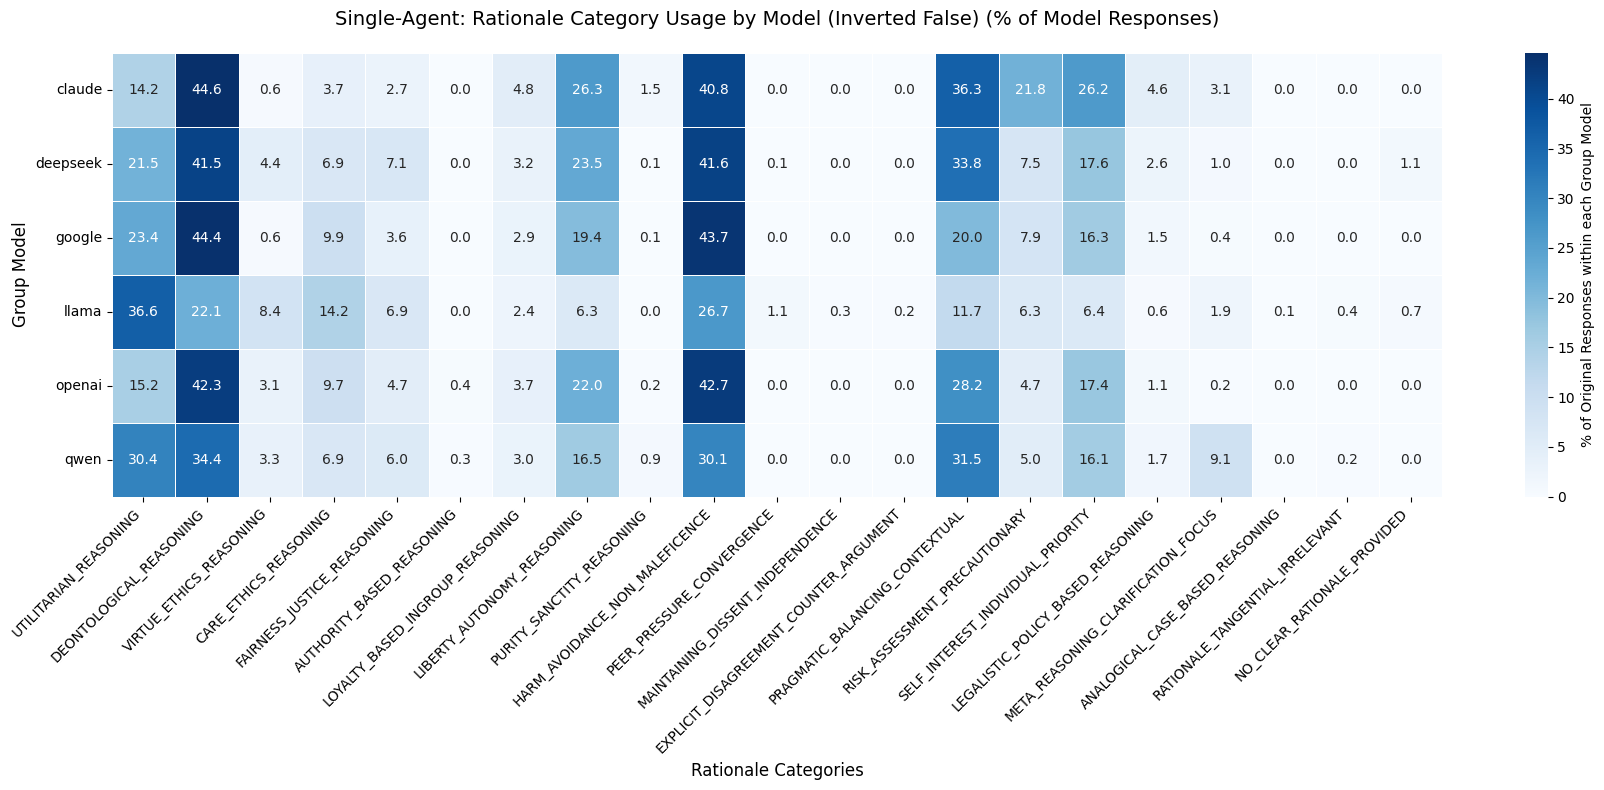


2. Single-Agent Category Usage by Model (Inverted True) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/single-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png


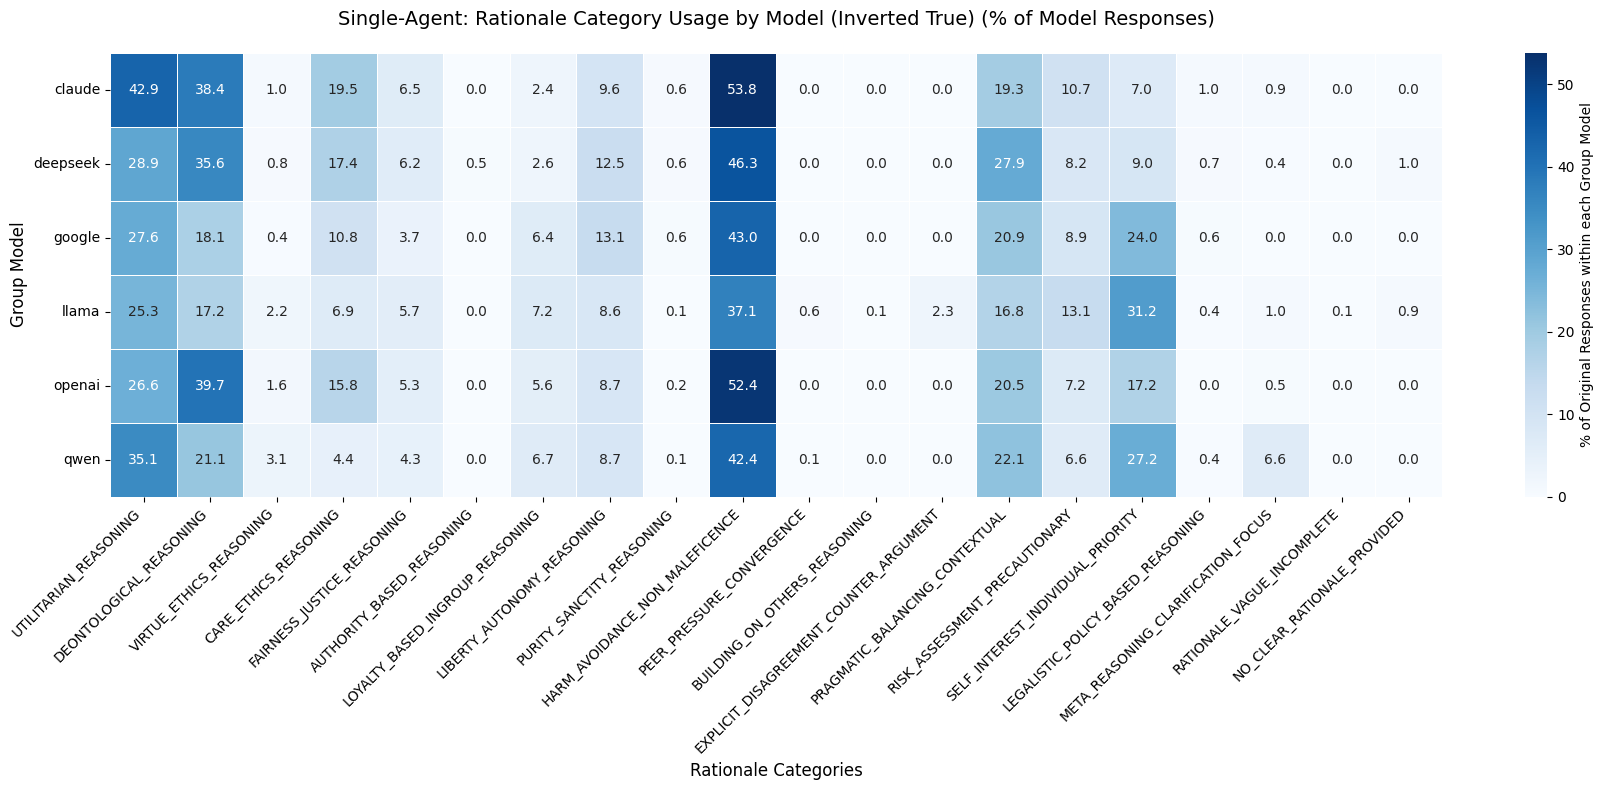


3. Ring Usage by Model (Inverted False) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


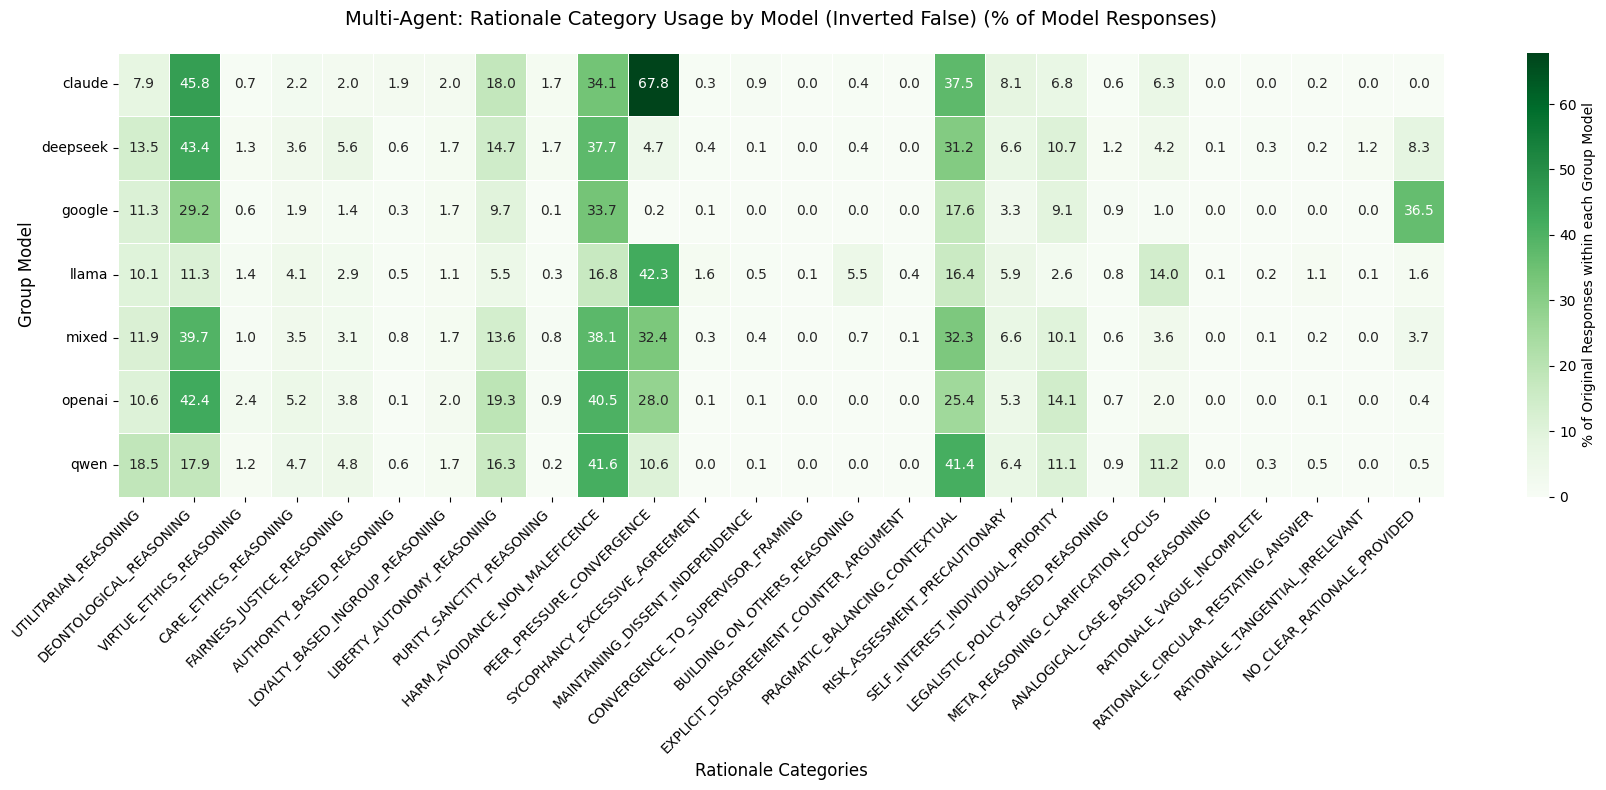


4. Ring Usage by Model (Inverted True) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_true)_(%_of_model_responses).png


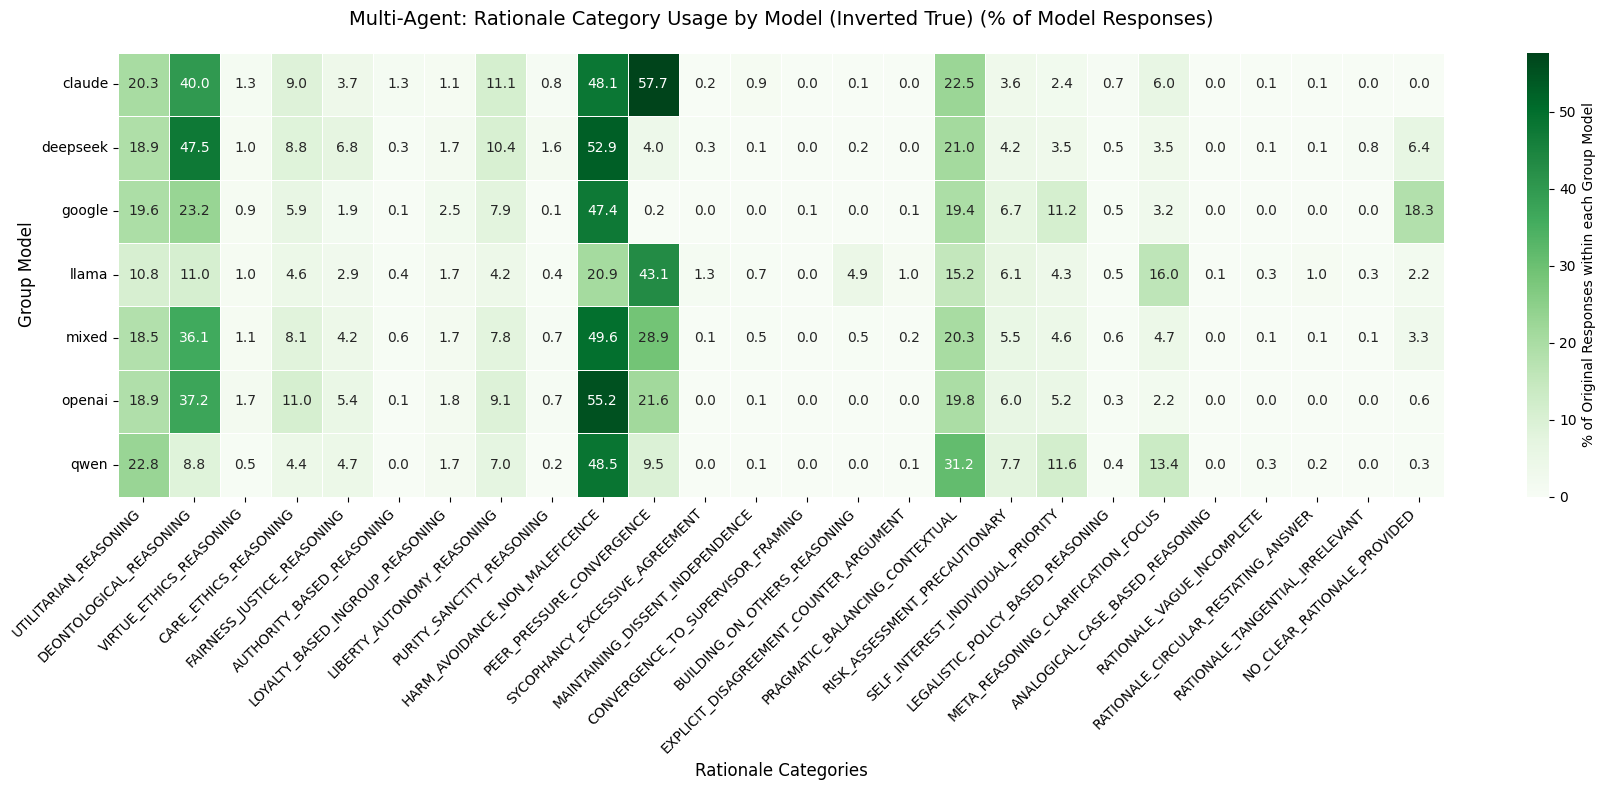


5. Star Usage by Inversion (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


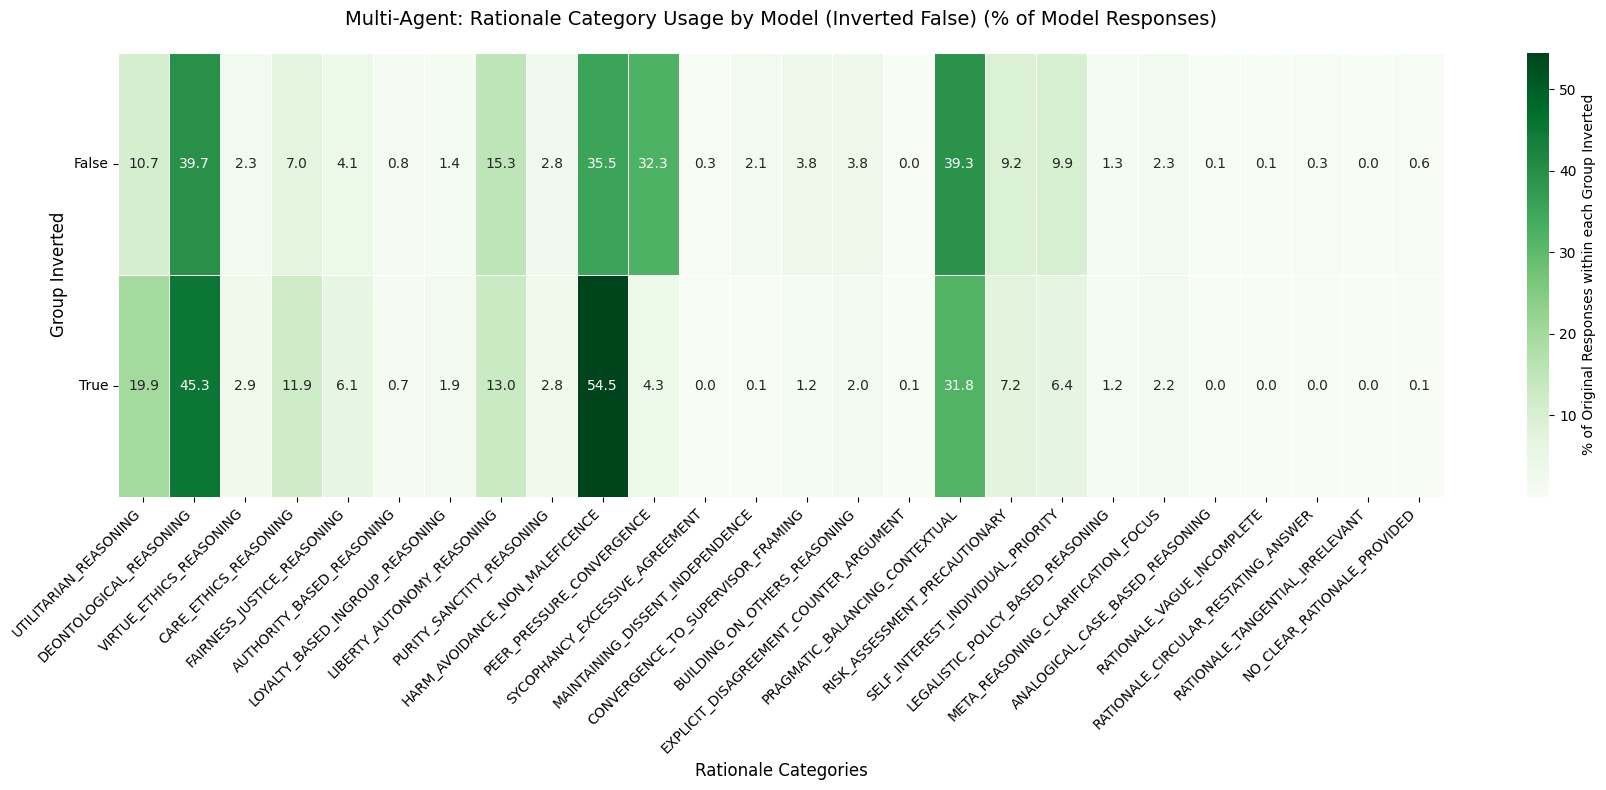


6. Star Usage by Evil (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/multi-agent:_rationale_category_usage_by_model_(inverted_false)_(%_of_model_responses).png


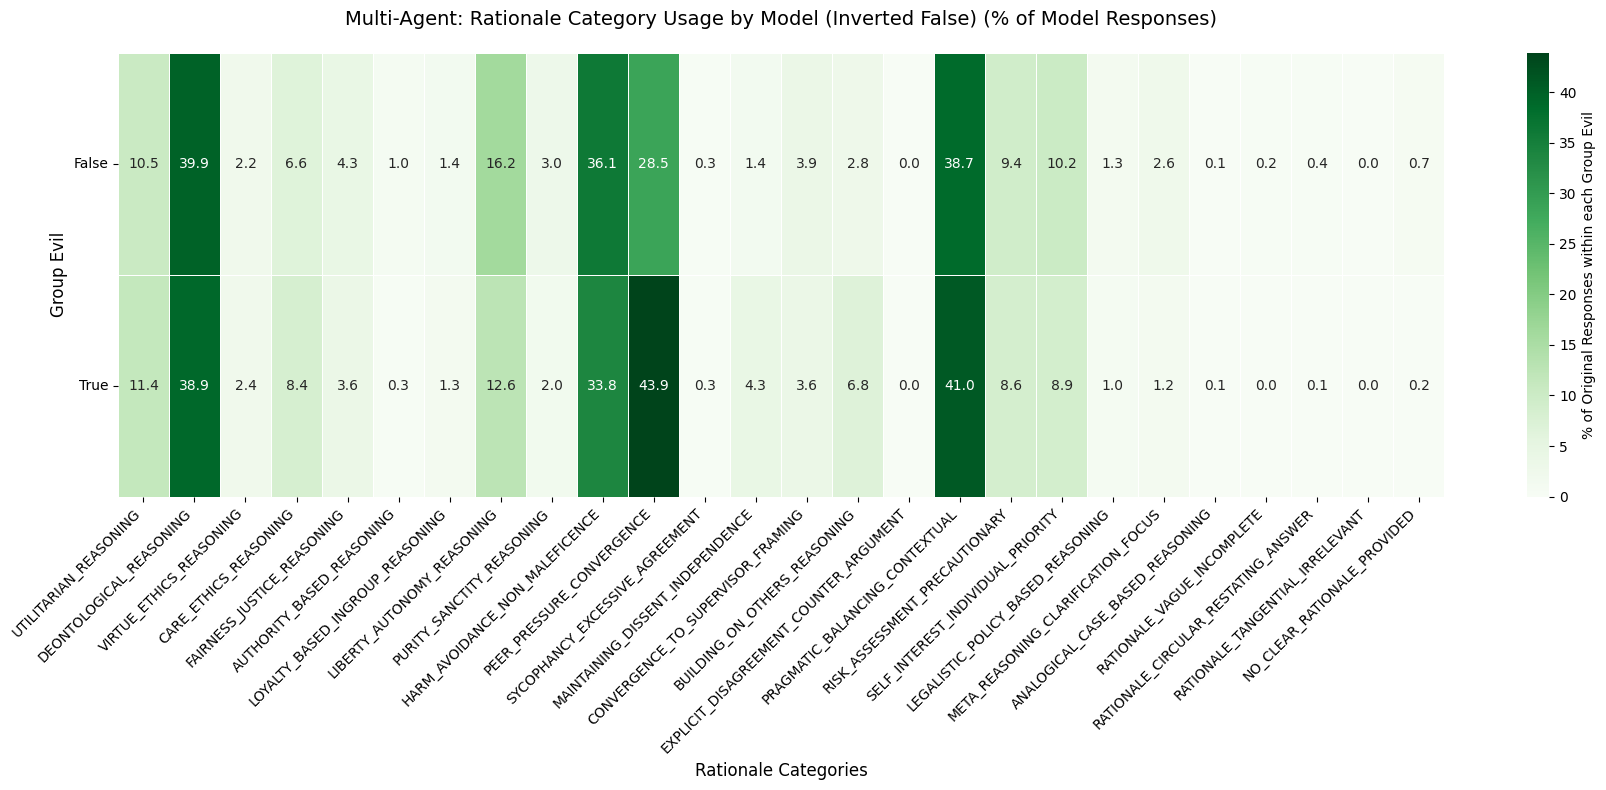


7. Inverted vs Not Inverted (remove Evil) (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/inverted_vs_not_inverted_(remove_evil)_(%).png


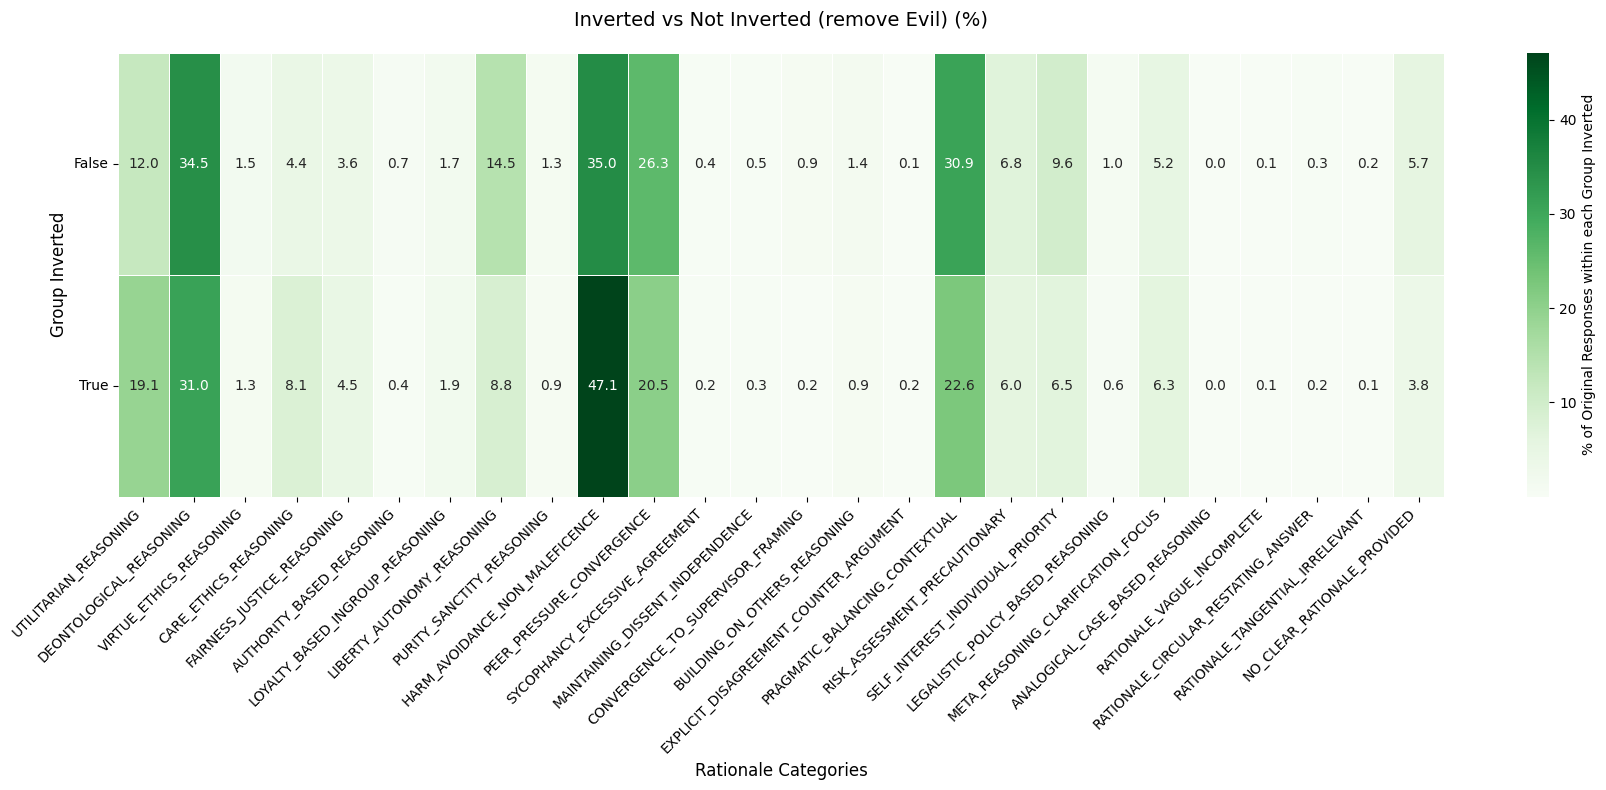

selected_categories,UTILITARIAN_REASONING,DEONTOLOGICAL_REASONING,VIRTUE_ETHICS_REASONING,CARE_ETHICS_REASONING,FAIRNESS_JUSTICE_REASONING,AUTHORITY_BASED_REASONING,LOYALTY_BASED_INGROUP_REASONING,LIBERTY_AUTONOMY_REASONING,PURITY_SANCTITY_REASONING,HARM_AVOIDANCE_NON_MALEFICENCE,...,PRAGMATIC_BALANCING_CONTEXTUAL,RISK_ASSESSMENT_PRECAUTIONARY,SELF_INTEREST_INDIVIDUAL_PRIORITY,LEGALISTIC_POLICY_BASED_REASONING,META_REASONING_CLARIFICATION_FOCUS,ANALOGICAL_CASE_BASED_REASONING,RATIONALE_VAGUE_INCOMPLETE,RATIONALE_CIRCULAR_RESTATING_ANSWER,RATIONALE_TANGENTIAL_IRRELEVANT,NO_CLEAR_RATIONALE_PROVIDED
group_inverted,,,,,,,,,,,,,,,,,,,,,
False,11.972919,34.500405,1.504337,4.376101,3.606401,0.725454,1.685492,14.504913,1.289789,35.032182,...,30.890247,6.835049,9.629175,0.970473,5.189628,0.042993,0.137744,0.319734,0.15611,5.686761
True,19.077443,31.036450,1.296089,8.084304,4.468725,0.422831,1.861111,8.842968,0.899919,47.089529,...,22.625201,5.992600,6.531897,0.592618,6.260612,0.018242,0.099159,0.191771,0.14453,3.806414


In [119]:
print(f"Total classification records: {len(combined_df)}")
print(f"Total exploded category instances: {len(exploded_df)}")
print(f"Topologies found: {combined_df['topology'].unique()}")

# plot across all group_inverted, group_type, group_model, group_evil

"""# HEATMAP 1: Single-Agent Category Usage by Model
single_agent_data_exploded = exploded_df[exploded_df['topology'] == 'Single-Agent']
single_agent_data = combined_df[combined_df['topology'] == 'Single-Agent']

print("\n1. Single-Agent Category Usage by Model (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='agent_model',
    title='Single-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# HEATMAP 2: Multi-Agent Category Usage by Model
multi_agent_data_exploded = exploded_df[exploded_df['topology'] == 'Multi-Agent']
multi_agent_data = combined_df[combined_df['topology'] == 'Multi-Agent']

print("\n2. Multi-Agent Category Usage by Model (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='agent_model',
    title='Multi-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)"""

# group agent single with agent category with not inverted by model
single_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'single') &  
    (exploded_df['group_inverted'] == False) & 
    (exploded_df['group_model'].notna())
]
single_agent_data = combined_df[
    (combined_df['group_type'] == 'single') &  
    (combined_df['group_inverted'] == False) & 
    (combined_df['group_model'].notna())
]
print("\n1. Single-Agent Category Usage by Model (Inverted False) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='group_model',
    title='Single-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# group agent single with agent category with inverted by model
single_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'single') &  
    (exploded_df['group_inverted'] == True) & 
    (exploded_df['group_model'].notna())
]
single_agent_data = combined_df[
    (combined_df['group_type'] == 'single') &  
    (combined_df['group_inverted'] == True) & 
    (combined_df['group_model'].notna())
]
print("\n2. Single-Agent Category Usage by Model (Inverted True) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=single_agent_data_exploded,
    unexploded_df_for_group_totals=single_agent_data,
    split_column='group_model',
    title='Single-Agent: Rationale Category Usage by Model (Inverted True) (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# ring with agent model with not inverted by model
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_inverted'] == False) & 
    (exploded_df['group_model'].notna())
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_inverted'] == False) & 
    (combined_df['group_model'].notna())
]
print("\n3. Ring Usage by Model (Inverted False) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_model',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# ring with agent model with inverted by model
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_inverted'] == True) & 
    (exploded_df['group_model'].notna())
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_inverted'] == True) & 
    (combined_df['group_model'].notna())
]

print("\n4. Ring Usage by Model (Inverted True) (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_model',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted True) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with agent model with and with not inversion
print("\n5. Star Usage by Inversion (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'star')
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'star')
]
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_inverted',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with / without evil
print("\n6. Star Usage by Evil (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_type'] == 'star' ) &
    (exploded_df['group_inverted'] == False)
]
multi_agent_data = combined_df[
    (combined_df['group_type'] == 'star') &
    (combined_df['group_inverted'] == False)
]
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_evil',
    title='Multi-Agent: Rationale Category Usage by Model (Inverted False) (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

# star with / without evil
print("\n7. Inverted vs Not Inverted (remove Evil) (%)")
multi_agent_data_exploded = exploded_df[
    (exploded_df['group_evil'] == False)
]
multi_agent_data = combined_df[
    (combined_df['group_evil'] == False)
]

create_heatmap_with_dual_dfs(
    exploded_data_for_counts=multi_agent_data_exploded,
    unexploded_df_for_group_totals=multi_agent_data,
    split_column='group_inverted',
    title='Inverted vs Not Inverted (remove Evil) (%)',
    cmap='Greens',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES
)

In [120]:
# get claude model runs in ring homo and hetero
print("Claude homo vs hetero")


Claude homo vs hetero


In [121]:
def classify_group_custom_type(group_type, group_model):
    """
    Classify group custom type based on group_type and group_model.
    Returns: group_custom_type
    """
    if group_type == 'single':
        return 'single'
    elif group_type == 'ring':
        if group_model == 'mixed':
            return 'ring_hetero'
        else:
            return 'ring_homo'
    elif group_type == 'star':
        return 'star'
    else:
        return 'unknown'

# Apply group custom type classification to both dataframes
combined_df['group_custom_type'] = combined_df.apply(
    lambda row: classify_group_custom_type(row['group_type'], row['group_model']), 
    axis=1
)

exploded_df['group_custom_type'] = exploded_df.apply(
    lambda row: classify_group_custom_type(row['group_type'], row['group_model']), 
    axis=1
)

print(f"Group custom type distribution in combined_df:")
print(combined_df['group_custom_type'].value_counts())

print(f"\nGroup custom type distribution in exploded_df:")
print(exploded_df['group_custom_type'].value_counts())

# Create custom combined dataframe - filter out group_evil data
custom_combined_df = combined_df[combined_df['group_evil'] == False].copy()
custom_exploded_df = exploded_df[exploded_df['group_evil'] == False].copy()

print(f"\nCustom dataframes created with group_custom_type column (filtering out group_evil)")
print(f"Original combined_df shape: {combined_df.shape}")
print(f"Custom combined_df shape (no evil): {custom_combined_df.shape}")
print(f"Original exploded_df shape: {exploded_df.shape}")
print(f"Custom exploded_df shape (no evil): {custom_exploded_df.shape}")

Group custom type distribution in combined_df:
group_custom_type
ring_homo      310905
star            94925
ring_hetero     51850
single          12960
Name: count, dtype: int64

Group custom type distribution in exploded_df:
group_custom_type
ring_homo      585590
star           211861
ring_hetero    104627
single          25298
Name: count, dtype: int64

Custom dataframes created with group_custom_type column (filtering out group_evil)
Original combined_df shape: (470640, 30)
Custom combined_df shape (no evil): (453371, 30)
Original exploded_df shape: (927376, 30)
Custom exploded_df shape (no evil): (886804, 30)



7. Category Usage by Group Custom Type (%)
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/rationale_category_usage_by_group_custom_type_(%_of_custom_type_responses).png


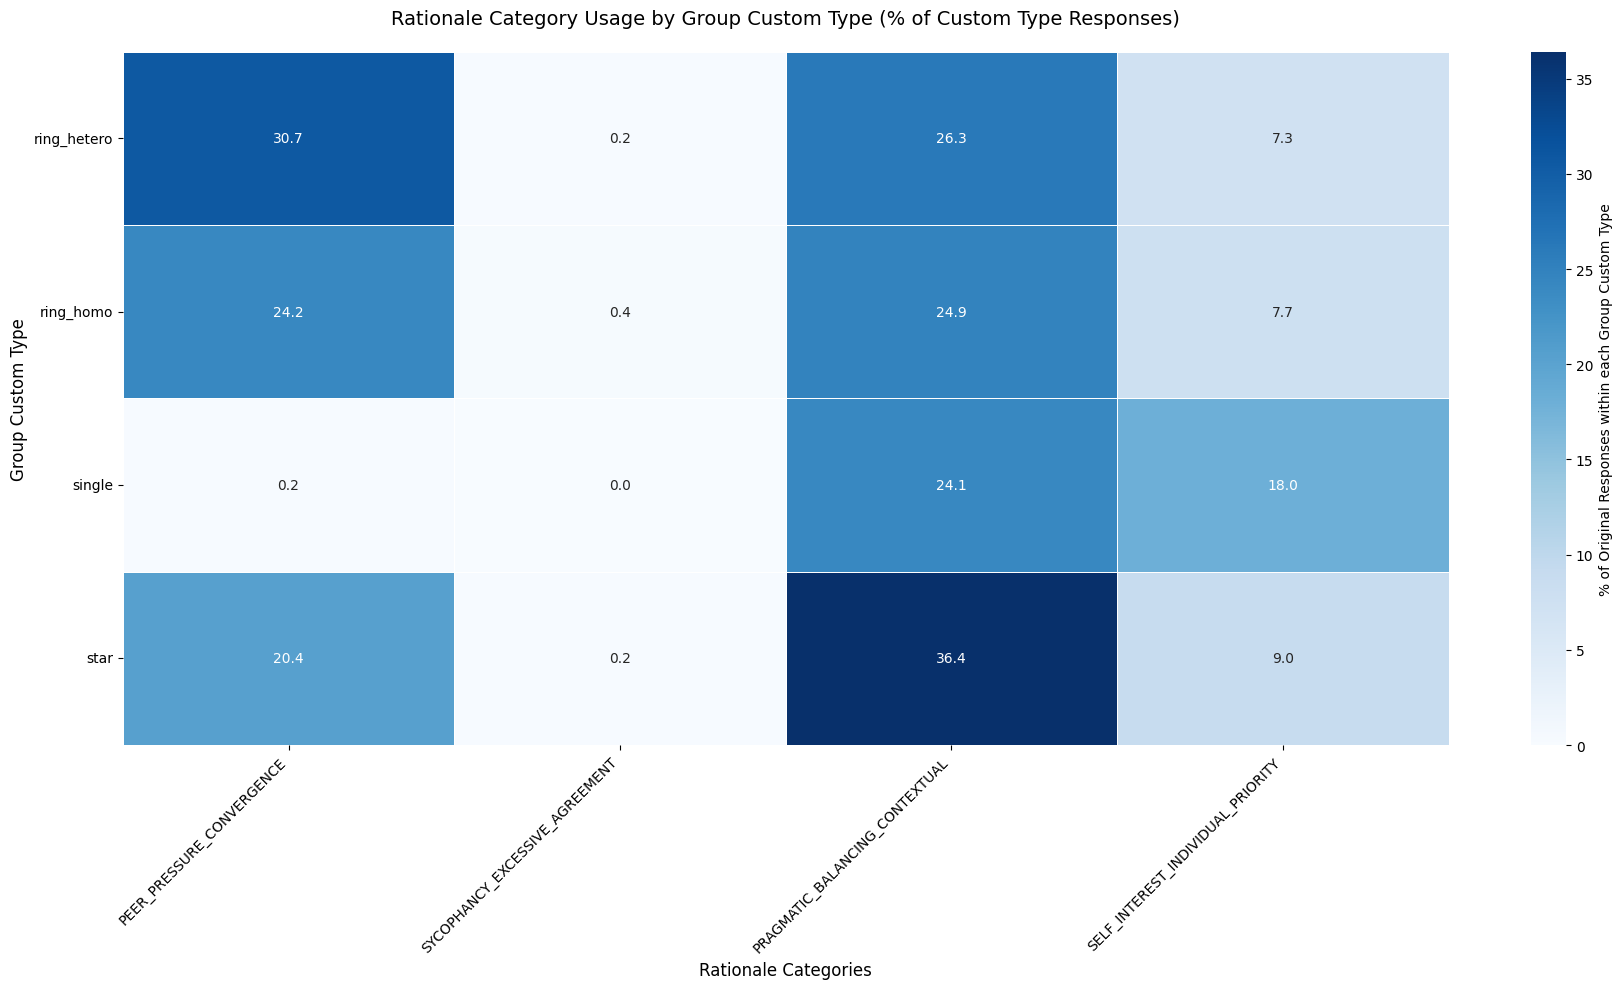

selected_categories,PEER_PRESSURE_CONVERGENCE,SYCOPHANCY_EXCESSIVE_AGREEMENT,PRAGMATIC_BALANCING_CONTEXTUAL,SELF_INTEREST_INDIVIDUAL_PRIORITY
group_custom_type,,,,
ring_hetero,30.653809,0.237223,26.287367,7.321119
ring_homo,24.153037,0.364098,24.878982,7.704283
single,0.162037,0.000000,24.074074,17.970679
star,20.436283,0.216339,36.413155,8.957453


In [122]:
# Generate heatmap split by group_custom_type
print("\n7. Category Usage by Group Custom Type (%)")
create_heatmap_with_dual_dfs(
    exploded_data_for_counts=custom_exploded_df,
    unexploded_df_for_group_totals=custom_combined_df,
    split_column='group_custom_type',
    title='Rationale Category Usage by Group Custom Type (% of Custom Type Responses)',
    cmap='Blues',
    figsize=(18, 10),
    ordered_categories=[
        "PEER_PRESSURE_CONVERGENCE",
        "SYCOPHANCY_EXCESSIVE_AGREEMENT",
        "PRAGMATIC_BALANCING_CONTEXTUAL",
        "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    ]
)

# =============================================================================

In [123]:
custom_combined_df.columns

Index(['question_id', 'agent_name', 'message_content', 'answer', 'confidence',
       'model_name', 'run_index', 'is_response_off_topic', 'off_topic_reason',
       'selected_categories', 'extracted_answer', 'extracted_confidence',
       'agent_model', 'topology', 'dataset', 'message_index', 'row_index',
       'error_type', 'error_message', 'classification_item_dict',
       'agent_responses_for_row_count', 'original_question',
       'agent_responses_str_snippet', 'question_inverted', 'question_category',
       'group_inverted', 'group_type', 'group_model', 'group_evil',
       'group_custom_type'],
      dtype='object')

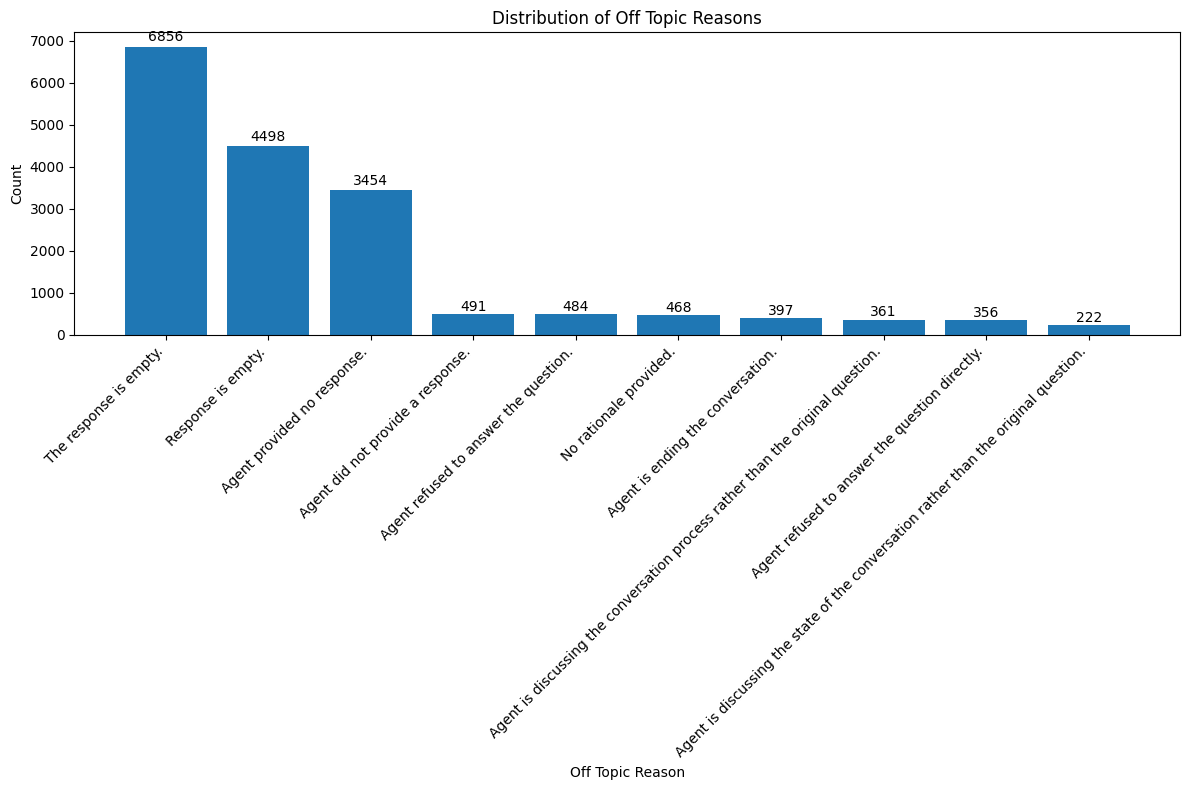

Off Topic Reason Value Counts:
off_topic_reason
The response is empty.                                                                  6856
Response is empty.                                                                      4498
Agent provided no response.                                                             3454
Agent did not provide a response.                                                        491
Agent refused to answer the question.                                                    484
No rationale provided.                                                                   468
Agent is ending the conversation.                                                        397
Agent is discussing the conversation process rather than the original question.          361
Agent refused to answer the question directly.                                           356
Agent is discussing the state of the conversation rather than the original question.     222
Name: count, dtype: in

In [124]:
# Create histogram of off_topic_reason values
off_topic_counts = combined_df['off_topic_reason'].value_counts()[:10]  # Get top 10 reasons for better visibility

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(off_topic_counts)), off_topic_counts.values)
plt.xlabel('Off Topic Reason')
plt.ylabel('Count')
plt.title('Distribution of Off Topic Reasons')
plt.xticks(range(len(off_topic_counts)), off_topic_counts.index, rotation=45, ha='right')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the value counts for reference
print("Off Topic Reason Value Counts:")
print(off_topic_counts)

In [125]:
total = len(combined_df)
off_topic = len(combined_df[combined_df['off_topic_reason'].notna()])

print(f"Total responses: {total}")
print(f"Responses with off-topic reasons: {off_topic} ({off_topic / total * 100:.2f}%)")


Total responses: 470640
Responses with off-topic reasons: 39079 (8.30%)


In [126]:
#print all of combined_df['off_topic_reason'].unique() to a file
off_topic_reasons = combined_df['off_topic_reason'].value_counts()
# print the keys to a file
off_topic_reasons_file = os.path.join(BASE_DIR, "off_topic_reasons.txt")
with open(off_topic_reasons_file, 'w') as f:
    for i, reason in enumerate(off_topic_reasons.index):
        f.write(f"{i+1}: {reason}\n")
print(f"Off topic reasons saved to {off_topic_reasons_file}")

Off topic reasons saved to /Users/ram/Github/wisdom_agents/off_topic_reasons.txt



8. Claude: Ring Mixed vs Ring Homogeneous (%)


/var/folders/8g/x9ncyhjj3wdchhjpvtkcr_640000gp/T/ipykernel_77428/2361090331.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ring_mixed_claude['claude_group_type'] = 'Mixed Group'
/var/folders/8g/x9ncyhjj3wdchhjpvtkcr_640000gp/T/ipykernel_77428/2361090331.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ring_homo_claude['claude_group_type'] = 'Homogeneous Group'
/var/folders/8g/x9ncyhjj3wdchhjpvtkcr_640000gp/T/ipykernel_77428/2361090331.py:29: SettingWithCopyWarning: 
A value is trying to be set on 

Ring Mixed Claude agents: 8634 responses
Ring Homogeneous Claude groups: 51848 responses
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/claude:_ring_mixed_vs_ring_homogeneous_groups_(%_of_group_responses).png


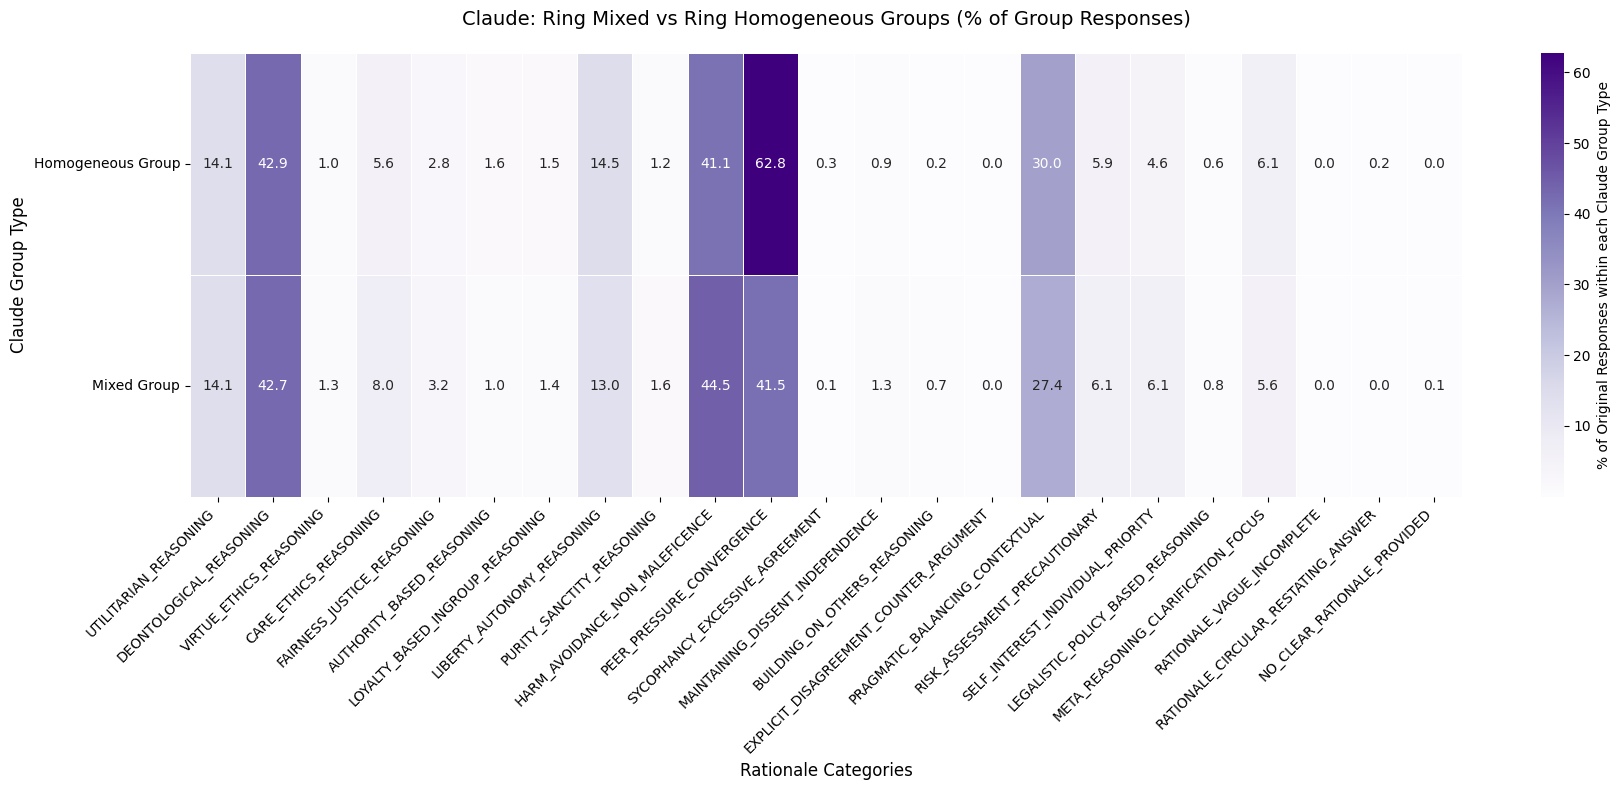

In [127]:
# Compare Claude in ring mixed vs ring homogeneous groups
print("\n8. Claude: Ring Mixed vs Ring Homogeneous (%)")

# Ring mixed with Claude agents
ring_mixed_claude_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_model'] == 'mixed') & 
    (exploded_df['model_name'].str.contains('claude', case=False, na=False))
]
ring_mixed_claude = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_model'] == 'mixed') & 
    (combined_df['model_name'].str.contains('claude', case=False, na=False))
]

# Ring homogeneous Claude groups
ring_homo_claude_exploded = exploded_df[
    (exploded_df['group_type'] == 'ring') &  
    (exploded_df['group_model'] == 'claude')
]
ring_homo_claude = combined_df[
    (combined_df['group_type'] == 'ring') &  
    (combined_df['group_model'] == 'claude')
]

# Combine both datasets and add a comparison column
ring_mixed_claude['claude_group_type'] = 'Mixed Group'
ring_homo_claude['claude_group_type'] = 'Homogeneous Group'
ring_mixed_claude_exploded['claude_group_type'] = 'Mixed Group'
ring_homo_claude_exploded['claude_group_type'] = 'Homogeneous Group'

# Combine the datasets
claude_comparison_combined = pd.concat([ring_mixed_claude, ring_homo_claude], ignore_index=True)
claude_comparison_exploded = pd.concat([ring_mixed_claude_exploded, ring_homo_claude_exploded], ignore_index=True)

print(f"Ring Mixed Claude agents: {len(ring_mixed_claude)} responses")
print(f"Ring Homogeneous Claude groups: {len(ring_homo_claude)} responses")

if len(claude_comparison_combined) > 0 and len(claude_comparison_exploded) > 0:
    create_heatmap_with_dual_dfs(
        exploded_data_for_counts=claude_comparison_exploded,
        unexploded_df_for_group_totals=claude_comparison_combined,
        split_column='claude_group_type',
        title='Claude: Ring Mixed vs Ring Homogeneous Groups (% of Group Responses)',
        cmap='Purples',
        figsize=(18, 8),
        ordered_categories=VALID_CATEGORY_NAMES
    )
else:
    print("No data found for Claude comparison")

=== Individual Model Comparisons ===

Claude: Ring Mixed vs Ring Homogeneous (%)
Ring Mixed Claude agents: 8634 responses
Ring Homogeneous Claude groups: 51848 responses
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/claude:_ring_mixed_vs_ring_homogeneous_groups_(%_of_group_responses).png


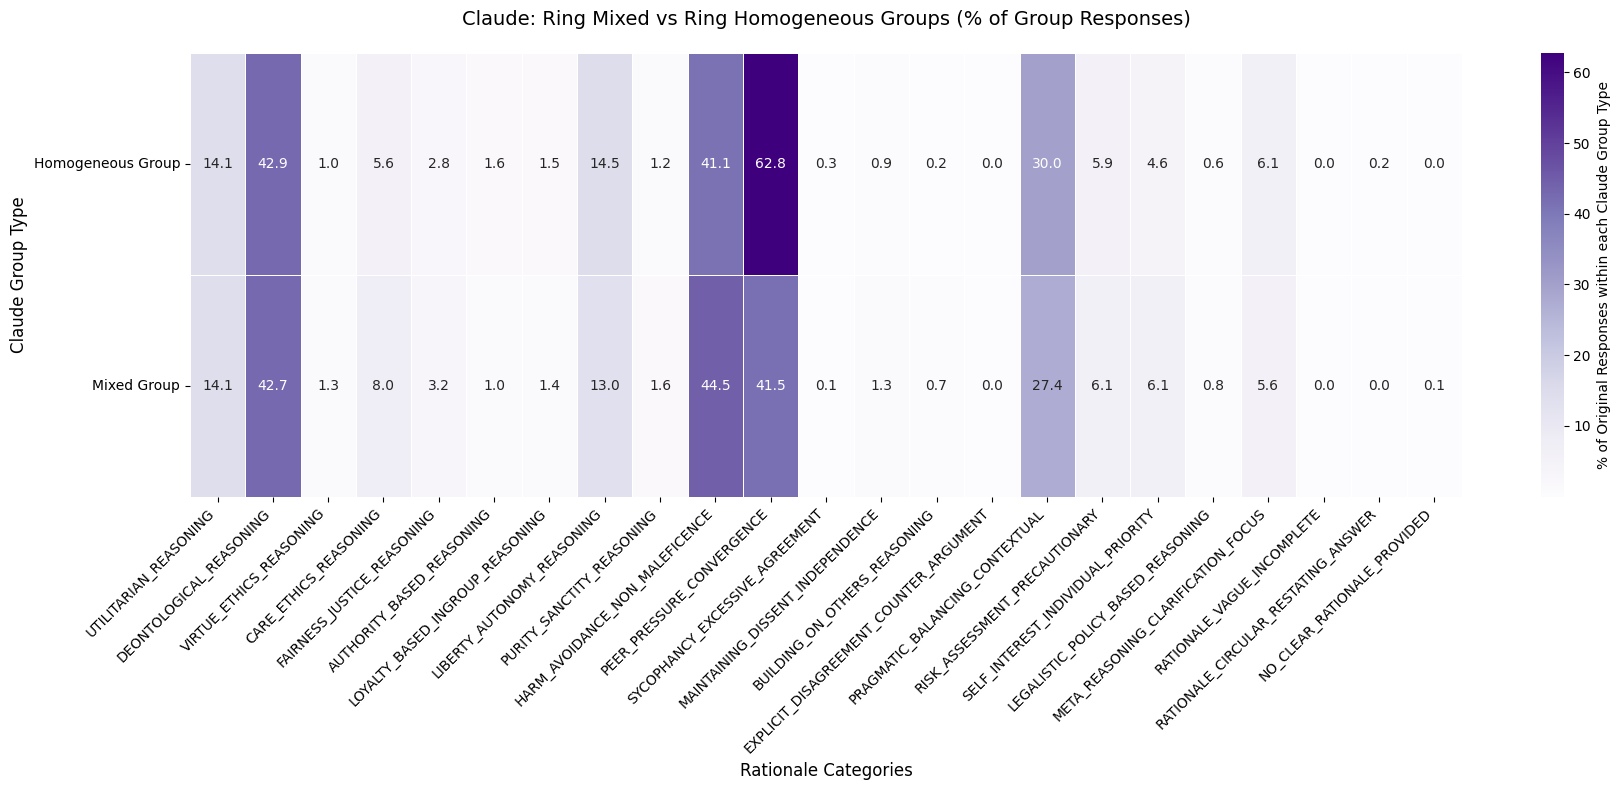


OpenAI: Ring Mixed vs Ring Homogeneous (%)
Ring Mixed OpenAI agents: 8636 responses
Ring Homogeneous OpenAI groups: 51817 responses
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/openai:_ring_mixed_vs_ring_homogeneous_groups_(%_of_group_responses).png


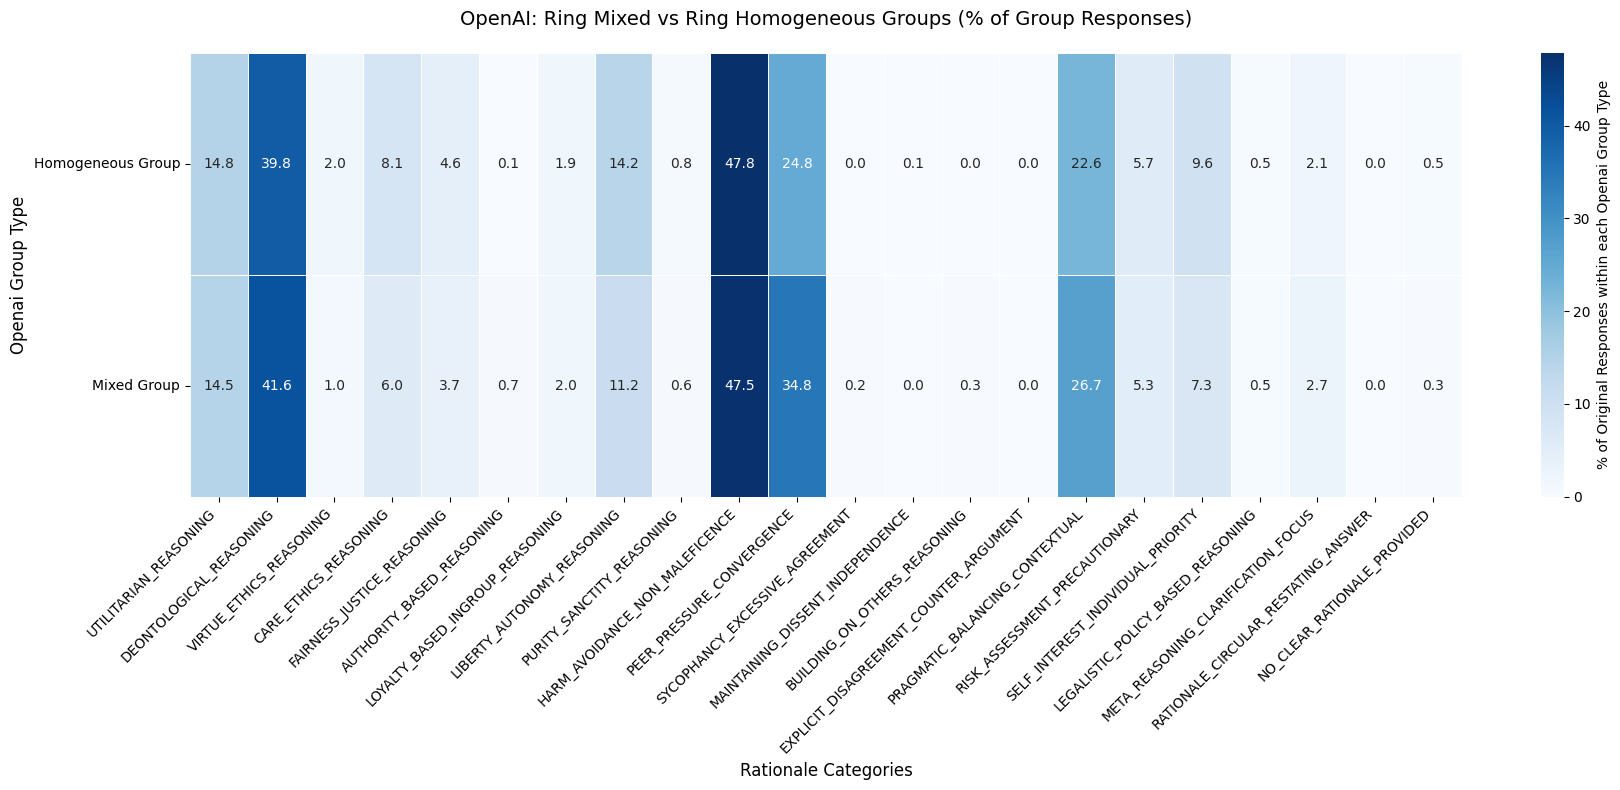


Google: Ring Mixed vs Ring Homogeneous (%)
Ring Mixed Google agents: 8633 responses
Ring Homogeneous Google groups: 51851 responses
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/google:_ring_mixed_vs_ring_homogeneous_groups_(%_of_group_responses).png


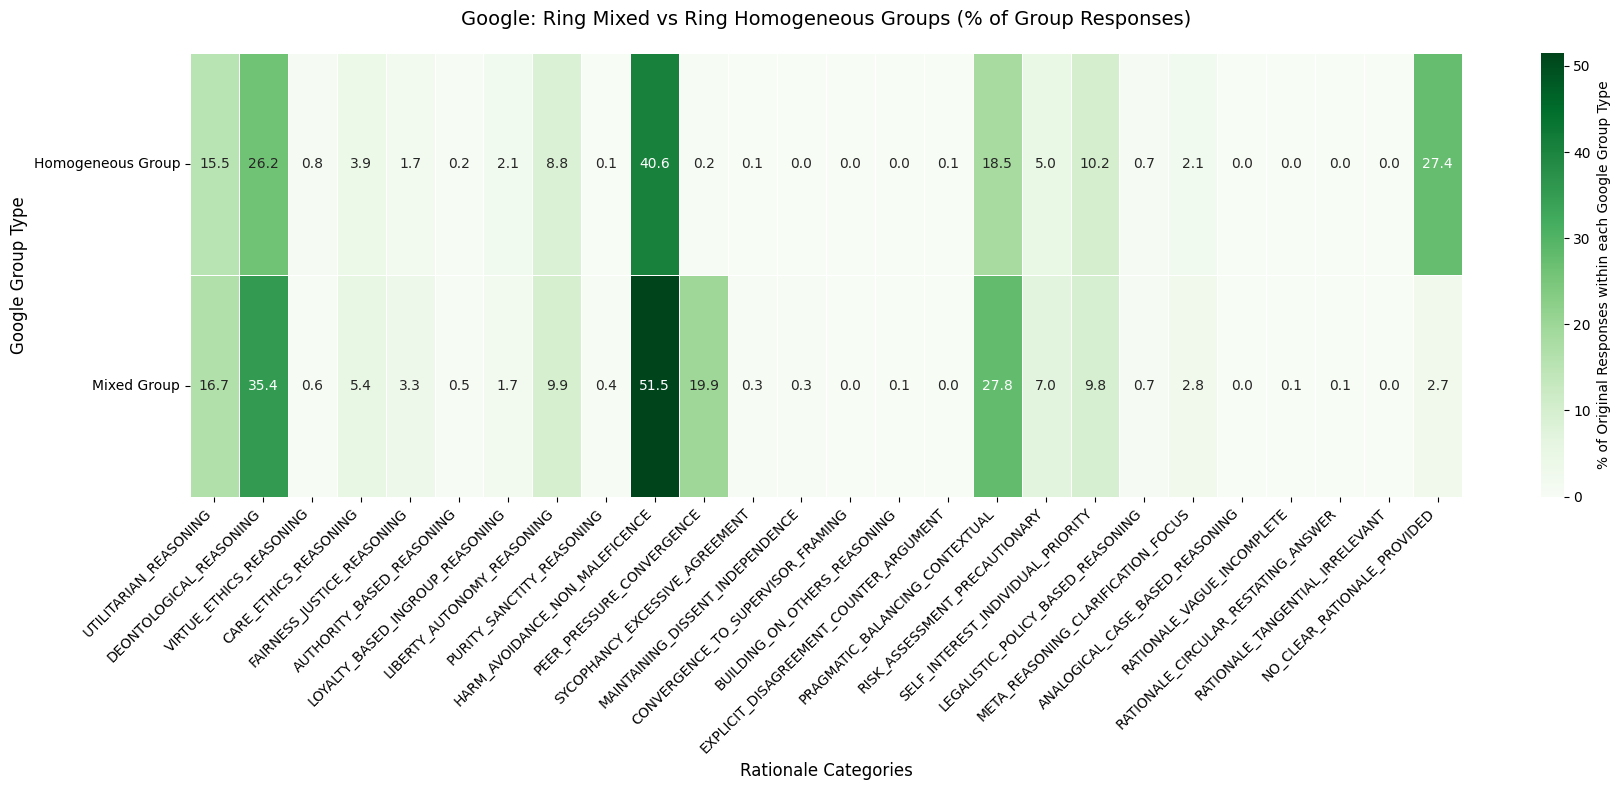


Llama: Ring Mixed vs Ring Homogeneous (%)
Ring Mixed Llama agents: 8636 responses
Ring Homogeneous Llama groups: 51832 responses
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/llama:_ring_mixed_vs_ring_homogeneous_groups_(%_of_group_responses).png


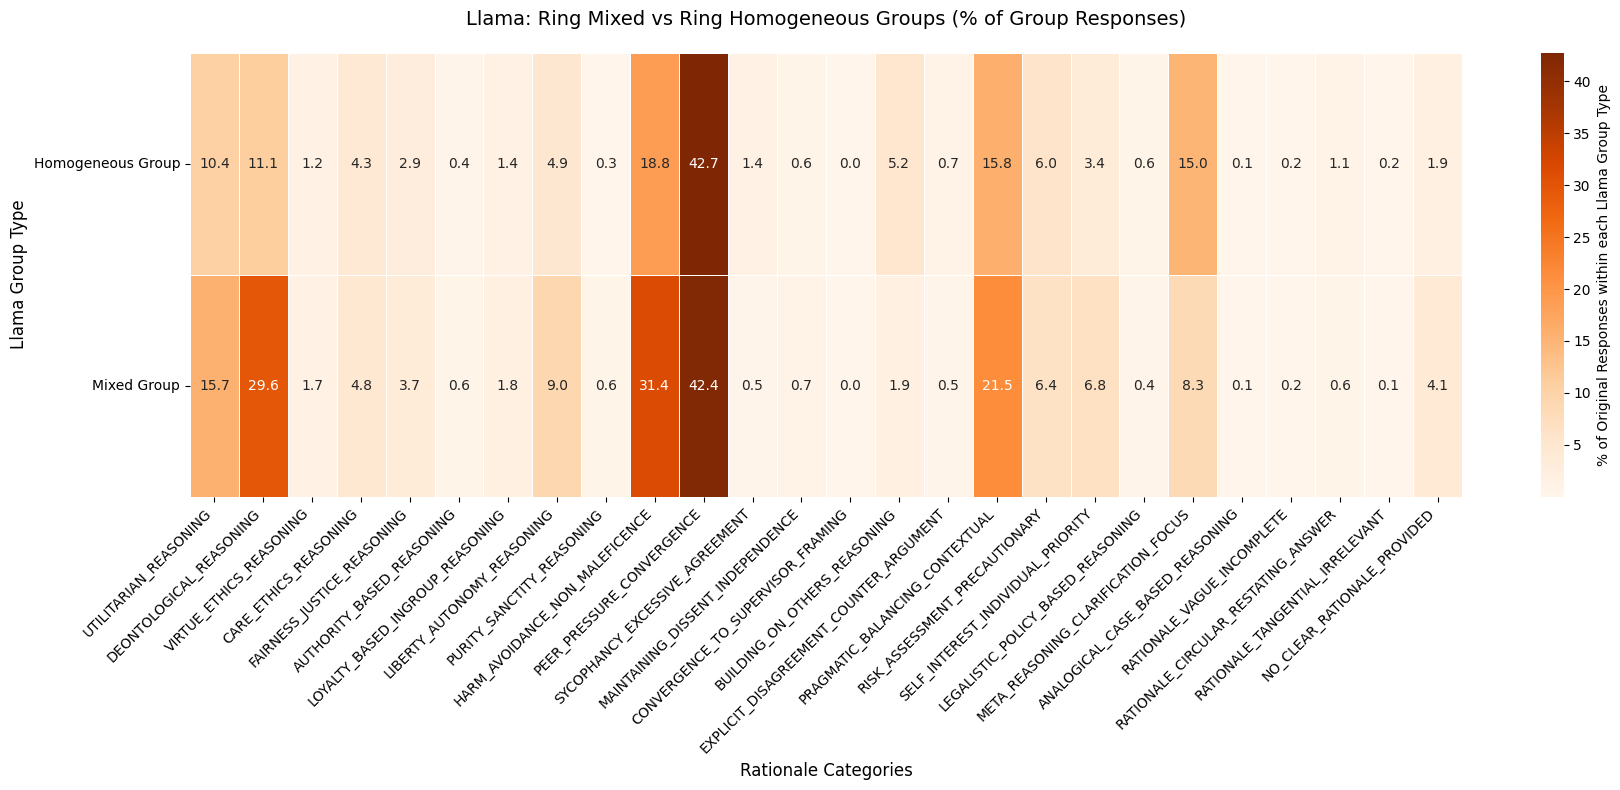


Qwen: Ring Mixed vs Ring Homogeneous (%)
Ring Mixed Qwen agents: 8636 responses
Ring Homogeneous Qwen groups: 51610 responses
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/qwen:_ring_mixed_vs_ring_homogeneous_groups_(%_of_group_responses).png


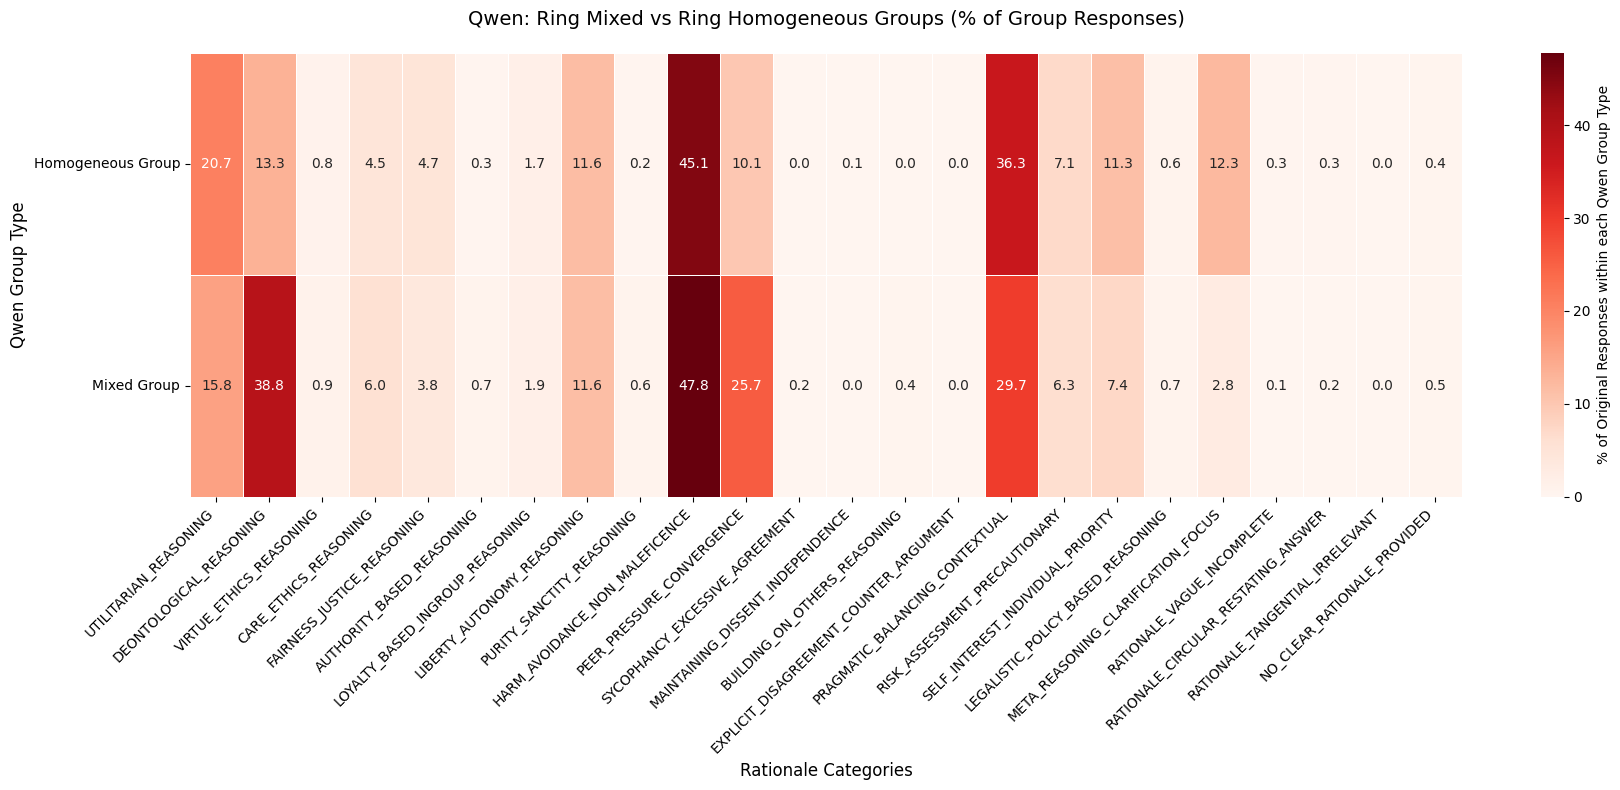


DeepSeek: Ring Mixed vs Ring Homogeneous (%)
Ring Mixed DeepSeek agents: 8635 responses
Ring Homogeneous DeepSeek groups: 51947 responses
Heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/deepseek:_ring_mixed_vs_ring_homogeneous_groups_(%_of_group_responses).png


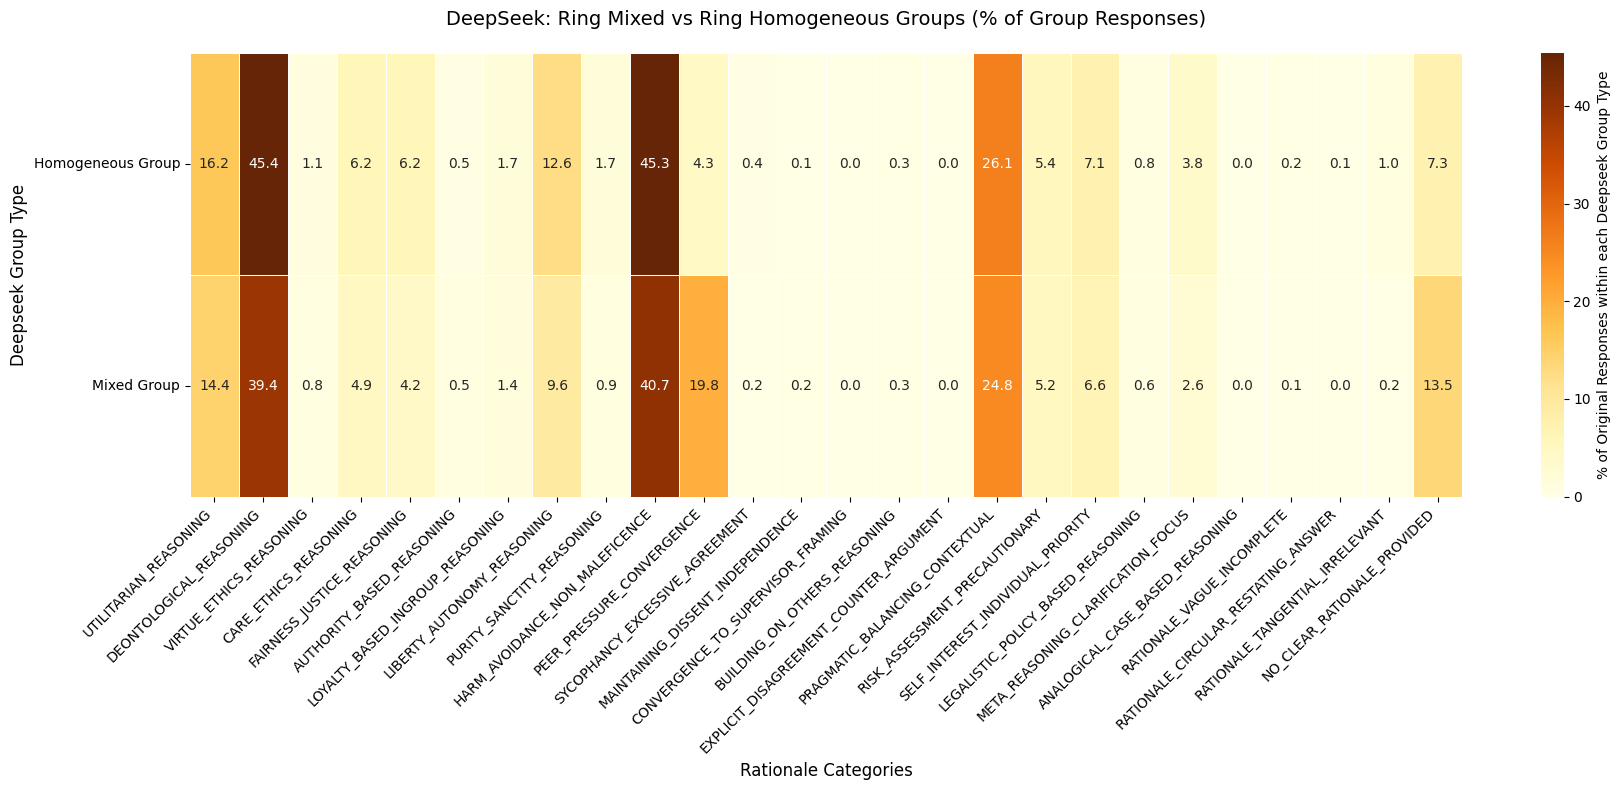

In [128]:
def compare_model_ring_mixed_vs_homo(model_name_pattern, model_display_name, exploded_df, combined_df, color_map='Purples'):
    """
    Compare a specific model's usage in ring mixed vs ring homogeneous groups.
    
    Args:
        model_name_pattern: String pattern to match in model_name column (case-insensitive)
        model_display_name: Display name for the model in titles
        exploded_df: Exploded dataframe for category counts
        combined_df: Combined dataframe for group totals
        color_map: Color palette for the heatmap
    """
    print(f"\n{model_display_name}: Ring Mixed vs Ring Homogeneous (%)")
    
    # Ring mixed with specific model agents
    ring_mixed_model_exploded = exploded_df[
        (exploded_df['group_type'] == 'ring') &  
        (exploded_df['group_model'] == 'mixed') & 
        (exploded_df['model_name'].str.contains(model_name_pattern, case=False, na=False))
    ]
    ring_mixed_model = combined_df[
        (combined_df['group_type'] == 'ring') &  
        (combined_df['group_model'] == 'mixed') & 
        (combined_df['model_name'].str.contains(model_name_pattern, case=False, na=False))
    ]
    
    # Ring homogeneous model groups (using group_model classification)
    # Map model_name_pattern to group_model value
    group_model_mapping = {
        'claude': 'claude',
        'openai|gpt': 'openai', 
        'google|gemini': 'google',
        'llama': 'llama',
        'qwen': 'qwen',
        'deepseek': 'deepseek'
    }
    
    group_model_value = None
    for pattern, value in group_model_mapping.items():
        if any(p in model_name_pattern.lower() for p in pattern.split('|')):
            group_model_value = value
            break
    
    if group_model_value is None:
        print(f"Warning: Could not map {model_name_pattern} to group_model value")
        return None
    
    ring_homo_model_exploded = exploded_df[
        (exploded_df['group_type'] == 'ring') &  
        (exploded_df['group_model'] == group_model_value)
    ]
    ring_homo_model = combined_df[
        (combined_df['group_type'] == 'ring') &  
        (combined_df['group_model'] == group_model_value)
    ]
    
    # Check if we have data
    if len(ring_mixed_model) == 0 and len(ring_homo_model) == 0:
        print(f"No data found for {model_display_name} comparison")
        return None
    
    # Combine both datasets and add a comparison column
    ring_mixed_model = ring_mixed_model.copy()
    ring_homo_model = ring_homo_model.copy()
    ring_mixed_model_exploded = ring_mixed_model_exploded.copy()
    ring_homo_model_exploded = ring_homo_model_exploded.copy()
    
    ring_mixed_model[f'{model_display_name.lower()}_group_type'] = 'Mixed Group'
    ring_homo_model[f'{model_display_name.lower()}_group_type'] = 'Homogeneous Group'
    ring_mixed_model_exploded[f'{model_display_name.lower()}_group_type'] = 'Mixed Group'
    ring_homo_model_exploded[f'{model_display_name.lower()}_group_type'] = 'Homogeneous Group'
    
    # Combine the datasets
    model_comparison_combined = pd.concat([ring_mixed_model, ring_homo_model], ignore_index=True)
    model_comparison_exploded = pd.concat([ring_mixed_model_exploded, ring_homo_model_exploded], ignore_index=True)
    
    print(f"Ring Mixed {model_display_name} agents: {len(ring_mixed_model)} responses")
    print(f"Ring Homogeneous {model_display_name} groups: {len(ring_homo_model)} responses")
    
    if len(model_comparison_combined) > 0 and len(model_comparison_exploded) > 0:
        pivot_data = create_heatmap_with_dual_dfs(
            exploded_data_for_counts=model_comparison_exploded,
            unexploded_df_for_group_totals=model_comparison_combined,
            split_column=f'{model_display_name.lower()}_group_type',
            title=f'{model_display_name}: Ring Mixed vs Ring Homogeneous Groups (% of Group Responses)',
            cmap=color_map,
            figsize=(18, 8),
            ordered_categories=VALID_CATEGORY_NAMES
        )
        return pivot_data
    else:
        print(f"No data found for {model_display_name} comparison")
        return None

# Define models to compare
models_to_compare = [
    ('claude', 'Claude', 'Purples'),
    ('openai|gpt', 'OpenAI', 'Blues'), 
    ('google|gemini', 'Google', 'Greens'),
    ('llama', 'Llama', 'Oranges'),
    ('qwen', 'Qwen', 'Reds'),
    ('deepseek', 'DeepSeek', 'YlOrBr')
]

# Store pivot data for averaging
all_pivot_data = []
model_names = []

print("=== Individual Model Comparisons ===")
# Generate comparisons for each model
for model_pattern, model_name, color_map in models_to_compare:
    pivot_data = compare_model_ring_mixed_vs_homo(
        model_pattern, model_name, exploded_df, combined_df, color_map
    )
    if pivot_data is not None:
        all_pivot_data.append(pivot_data)
        model_names.append(model_name)

In [129]:
# 


=== Average Across All Models ===

Averaging across 6 models: Claude, OpenAI, Google, Llama, Qwen, DeepSeek
Average heatmap saved to /Users/ram/Github/wisdom_agents/heatmaps/average_ring_mixed_vs_homogeneous_groups.png


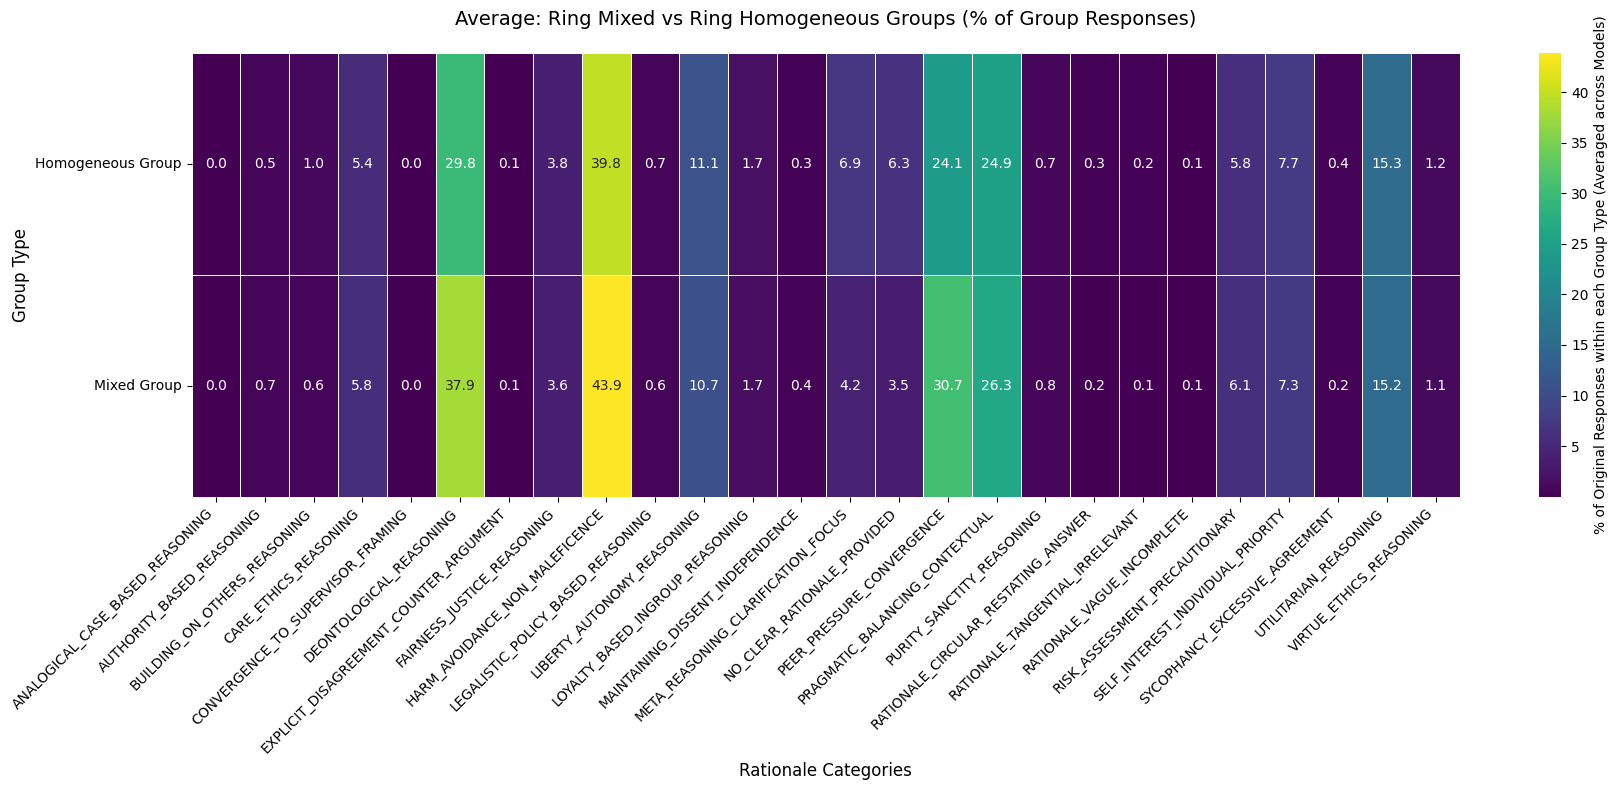


Averaged data shape: (2, 26)
Models included in average: Claude, OpenAI, Google, Llama, Qwen, DeepSeek


In [130]:
# Create average across all models
print("\n=== Average Across All Models ===")
if len(all_pivot_data) > 0:
    print(f"\nAveraging across {len(all_pivot_data)} models: {', '.join(model_names)}")
    
    # Ensure all pivot tables have the same structure
    all_categories = set()
    all_group_types = set()
    
    for pivot_data in all_pivot_data:
        all_categories.update(pivot_data.columns)
        all_group_types.update(pivot_data.index)
    
    all_categories = sorted(list(all_categories))
    all_group_types = sorted(list(all_group_types))
    
    # Reindex all pivot tables to have the same structure
    standardized_pivots = []
    for pivot_data in all_pivot_data:
        standardized = pivot_data.reindex(index=all_group_types, columns=all_categories, fill_value=0.0)
        standardized_pivots.append(standardized)
    
    # Calculate average
    if len(standardized_pivots) > 0:
        # Calculate mean across all standardized pivot tables
        averaged_pivot = pd.concat(standardized_pivots).groupby(level=0).mean()
        
        # Ensure proper ordering
        averaged_pivot = averaged_pivot.reindex(index=all_group_types, columns=all_categories, fill_value=0.0)
        
        # Plot the averaged heatmap
        plt.figure(figsize=(18, 8))
        cbar_label = '% of Original Responses within each Group Type (Averaged across Models)'
        sns.heatmap(averaged_pivot,
                    annot=True,
                    fmt='.1f',
                    cmap='viridis',
                    cbar_kws={'label': cbar_label},
                    linewidths=0.5)
        plt.title('Average: Ring Mixed vs Ring Homogeneous Groups (% of Group Responses)', fontsize=14, pad=20)
        plt.xlabel('Rationale Categories', fontsize=12)
        plt.ylabel('Group Type', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        # Save the heatmap
        output_dir = os.path.join(BASE_DIR, "heatmaps")
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, "average_ring_mixed_vs_homogeneous_groups.png")
        plt.savefig(output_file)
        print(f"Average heatmap saved to {output_file}")
        
        plt.show()
        plt.close()
        
        print(f"\nAveraged data shape: {averaged_pivot.shape}")
        print(f"Models included in average: {', '.join(model_names)}")
    else:
        print("No standardized pivot data available for averaging")
else:
    print("No pivot data available for averaging")

In [131]:
def create_peer_pressure_comparison_plots(all_pivot_data, model_names):
    """
    Create 6 side-by-side heatmaps showing only PEER_PRESSURE_CONVERGENCE
    for all models (excluding Google) plus average.
    """
    # Check if PEER_PRESSURE_CONVERGENCE exists in the data
    category_to_show = 'PEER_PRESSURE_CONVERGENCE'
    
    # Verify the category exists in at least one pivot table
    category_exists = False
    for pivot_data in all_pivot_data:
        if category_to_show in pivot_data.columns:
            category_exists = True
            break
    
    if not category_exists:
        print(f"Warning: {category_to_show} not found in any pivot data")
        return
    
    # Filter out Google from the analysis
    filtered_pivot_data = []
    filtered_model_names = []
    for pivot_data, model_name in zip(all_pivot_data, model_names):
        if model_name.lower() != 'google':
            filtered_pivot_data.append(pivot_data)
            filtered_model_names.append(model_name)
    
    # Reorder models: Claude, Llama, OpenAI, Qwen, DeepSeek
    desired_order = ['Claude', 'Llama', 'OpenAI', 'Qwen', 'DeepSeek']
    reordered_pivot_data = []
    reordered_model_names = []
    
    for desired_model in desired_order:
        for i, model_name in enumerate(filtered_model_names):
            if model_name == desired_model:
                reordered_pivot_data.append(filtered_pivot_data[i])
                reordered_model_names.append(model_name)
                break
    
    # Use reordered data
    filtered_pivot_data = reordered_pivot_data
    filtered_model_names = reordered_model_names
    
    # Calculate average across filtered models
    if len(filtered_pivot_data) > 0:
        # Ensure all pivot tables have the same structure
        all_categories = set()
        all_group_types = set()
        
        for pivot_data in filtered_pivot_data:
            all_categories.update(pivot_data.columns)
            all_group_types.update(pivot_data.index)
        
        all_categories = sorted(list(all_categories))
        all_group_types = sorted(list(all_group_types))
        
        # Reindex all pivot tables to have the same structure
        standardized_pivots = []
        for pivot_data in filtered_pivot_data:
            standardized = pivot_data.reindex(index=all_group_types, columns=all_categories, fill_value=0.0)
            standardized_pivots.append(standardized)
        
        # Calculate average
        averaged_pivot = pd.concat(standardized_pivots).groupby(level=0).mean()
        averaged_pivot = averaged_pivot.reindex(index=all_group_types, columns=all_categories, fill_value=0.0)
    else:
        print("No pivot data available for comparison plots")
        return
    
    # Create subplot figure with 6 columns (5 models + 1 average)
    num_plots = len(filtered_pivot_data) + 1
    fig, axes = plt.subplots(1, num_plots, figsize=(24, 6))
    
    # Color maps for each model in the new order
    color_maps = ['Blues', 'Blues', 'Blues', 'Blues', 'Blues']
    
    # Plot individual models
    for i, (pivot_data, model_name, cmap) in enumerate(zip(filtered_pivot_data, filtered_model_names, color_maps)):
        if category_to_show in pivot_data.columns:
            # Extract only the PEER_PRESSURE_CONVERGENCE column
            peer_pressure_data = pivot_data[[category_to_show]]
            
            # Rename index labels for display
            peer_pressure_data.index = peer_pressure_data.index.map(
                lambda x: 'Mixed' if 'Mixed' in str(x) else 'Homo'
            )
            
            # Create heatmap
            sns.heatmap(peer_pressure_data,
                       annot=True,
                       fmt='.1f',
                       cmap=cmap,
                       ax=axes[i],
                       cbar=False,  # Remove individual colorbars
                       linewidths=0.5,
                       vmin=0,
                       vmax=70,  # Set consistent scale
                       annot_kws={'fontsize': 32})  # Increase annotation font size
            
            axes[i].set_title(f'{model_name}', fontsize=14, pad=15)
            axes[i].set_xlabel('')
            if i == 0:
                axes[i].set_ylabel('Group Type', fontsize=12)
                axes[i].tick_params(axis='y', labelsize=16)  # Increase y-axis label size
            else:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])
            
            # Remove x-axis labels for cleaner look
            axes[i].set_xticklabels([])
        else:
            # If category doesn't exist, create empty plot
            axes[i].text(0.5, 0.5, f'No {category_to_show}\ndata for {model_name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{model_name}', fontsize=14, pad=15)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
    
    # Plot average in the last subplot
    if category_to_show in averaged_pivot.columns:
        peer_pressure_avg = averaged_pivot[[category_to_show]]
        
        # Rename index labels for display
        peer_pressure_avg.index = peer_pressure_avg.index.map(
            lambda x: 'Mixed' if 'Mixed' in str(x) else 'Homo'
        )
        
        sns.heatmap(peer_pressure_avg,
                   annot=True,
                   fmt='.1f',
                   cmap='Blues',
                   ax=axes[-1],
                   cbar=True,  # Show colorbar only for the last plot
                   linewidths=0.5,
                   vmin=0,
                   vmax=70,
                   cbar_kws={'label': '% of Group Responses'},
                   annot_kws={'fontsize': 32})  # Increase annotation font size
        
        axes[-1].set_title('Average', fontsize=14, pad=15)
        axes[-1].set_xlabel('')
        axes[-1].set_ylabel('')
        axes[-1].set_yticklabels([])
        axes[-1].set_xticklabels([])
    else:
        axes[-1].text(0.5, 0.5, f'No {category_to_show}\ndata for average', 
                    ha='center', va='center', transform=axes[-1].transAxes)
        axes[-1].set_title('Average', fontsize=14, pad=15)
        axes[-1].set_xticks([])
        axes[-1].set_yticks([])
    
    # Set overall title
    fig.suptitle(f'{category_to_show.replace("_", " ").title()}: Ring Mixed vs Ring Homogeneous Groups', 
                fontsize=18, y=0.95)
    
    plt.tight_layout()
    
    # Save the plot
    output_dir = os.path.join(BASE_DIR, "heatmaps")
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"peer_pressure_convergence_comparison_6_models.png")
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    print(f"Peer pressure comparison plot saved to {output_file}")
    
    plt.show()
    plt.close()


=== Peer Pressure Convergence Scatter Plot with Overall Trend Line (Including Google) ===
Scatter plot with overall trend line saved to /Users/ram/Github/wisdom_agents/heatmaps/peer_pressure_scatter_with_overall_trend.png


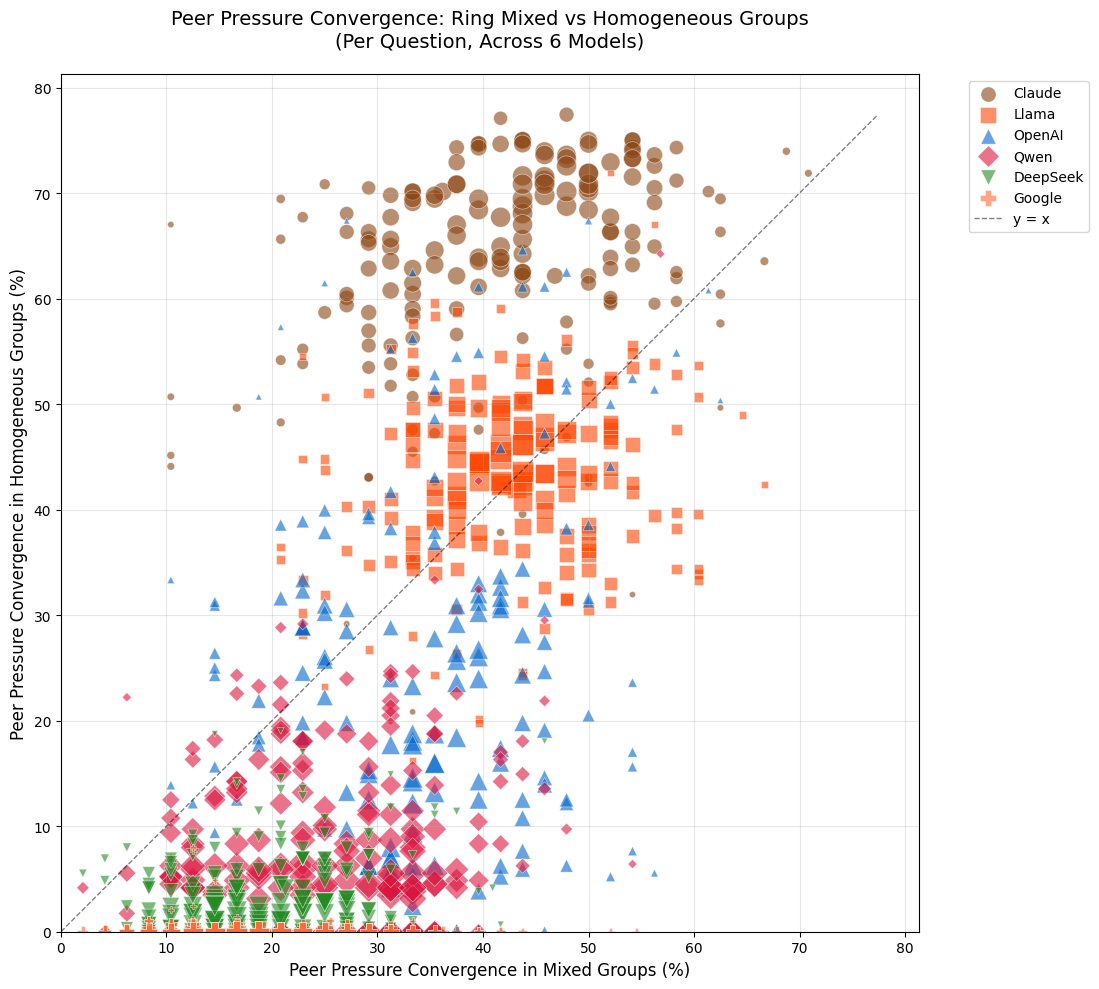


Summary Statistics:
Total data points: 1080
Questions covered: 180
Models included: Claude, Llama, OpenAI, Qwen, DeepSeek, Google

R² Values for Individual Models:
  Claude: 0.0986
  Llama: 0.0286
  OpenAI: 0.0416
  Qwen: 0.0625
  DeepSeek: 0.0407
  Google: 0.0168

Overall R² Value (All Models Combined): 0.4105
Overall correlation between Mixed and Homogeneous: 0.641


In [132]:
def create_peer_pressure_scatter_plot():
    """
    Create a scatter plot comparing peer pressure convergence values between 
    ring homogeneous (y-axis) and mixed (x-axis) groups for each question
    across the 6 models (including Google/Gemini) with scatter densities and R² values.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    
    # Define the 6 models to include (now including Google/Gemini)
    models_to_include = ['Claude', 'Llama', 'OpenAI', 'Qwen', 'DeepSeek', 'Google']
    model_mapping = {
        'claude': 'Claude',
        'llama': 'Llama', 
        'openai': 'OpenAI',
        'qwen': 'Qwen',
        'deepseek': 'DeepSeek',
        'google': 'Google'
    }
    
    # Filter data for peer pressure convergence category
    peer_pressure_data = exploded_df[
        (exploded_df['selected_categories'] == 'PEER_PRESSURE_CONVERGENCE') &
        (exploded_df['group_type'] == 'ring') &
        (exploded_df['group_model'].isin(['mixed', 'claude', 'llama', 'openai', 'qwen', 'deepseek', 'google']))
    ].copy()
    
    if peer_pressure_data.empty:
        print("No peer pressure convergence data found for ring topology")
        return
    
    # Create group type labels
    peer_pressure_data['group_composition'] = peer_pressure_data['group_model'].apply(
        lambda x: 'Mixed' if x == 'mixed' else 'Homogeneous'
    )
    
    # Map group_model to standardized model names for homogeneous groups
    peer_pressure_data['model_standardized'] = peer_pressure_data['group_model'].map(model_mapping)
    
    # For mixed groups, extract model from model_name column
    mixed_mask = peer_pressure_data['group_composition'] == 'Mixed'
    for model_key, model_name in model_mapping.items():
        model_pattern_mask = peer_pressure_data['model_name'].str.contains(model_key, case=False, na=False)
        peer_pressure_data.loc[mixed_mask & model_pattern_mask, 'model_standardized'] = model_name
    
    # Filter to only include the 6 models
    peer_pressure_data = peer_pressure_data[
        peer_pressure_data['model_standardized'].isin(models_to_include)
    ]
    
    if peer_pressure_data.empty:
        print("No data found for the 6 specified models")
        return
    
    # Calculate percentage of responses with peer pressure convergence per question per model per group type
    total_responses = combined_df[
        (combined_df['group_type'] == 'ring') &
        (combined_df['group_model'].isin(['mixed', 'claude', 'llama', 'openai', 'qwen', 'deepseek', 'google']))
    ].copy()
    
    # Add same labeling to total_responses
    total_responses['group_composition'] = total_responses['group_model'].apply(
        lambda x: 'Mixed' if x == 'mixed' else 'Homogeneous'
    )
    total_responses['model_standardized'] = total_responses['group_model'].map(model_mapping)
    
    # For mixed groups in total_responses
    mixed_mask_total = total_responses['group_composition'] == 'Mixed'
    for model_key, model_name in model_mapping.items():
        model_pattern_mask = total_responses['model_name'].str.contains(model_key, case=False, na=False)
        total_responses.loc[mixed_mask_total & model_pattern_mask, 'model_standardized'] = model_name
    
    total_responses = total_responses[
        total_responses['model_standardized'].isin(models_to_include)
    ]
    
    # Count peer pressure responses by question, model, and group composition
    peer_pressure_counts = peer_pressure_data.groupby(
        ['question_id', 'model_standardized', 'group_composition']
    ).size().reset_index(name='peer_pressure_count')
    
    # Count total responses by question, model, and group composition
    total_counts = total_responses.groupby(
        ['question_id', 'model_standardized', 'group_composition']
    ).size().reset_index(name='total_count')
    
    # Merge counts
    merged_data = pd.merge(
        total_counts, 
        peer_pressure_counts, 
        on=['question_id', 'model_standardized', 'group_composition'],
        how='left'
    )
    merged_data['peer_pressure_count'] = merged_data['peer_pressure_count'].fillna(0)
    
    # Calculate percentage
    merged_data['peer_pressure_percentage'] = (
        merged_data['peer_pressure_count'] / merged_data['total_count'] * 100
    )
    
    # Pivot to get homogeneous and mixed values side by side
    pivot_data = merged_data.pivot_table(
        index=['question_id', 'model_standardized'],
        columns='group_composition',
        values='peer_pressure_percentage',
        fill_value=0
    ).reset_index()
    
    # Filter out rows where either value is missing
    pivot_data = pivot_data.dropna(subset=['Homogeneous', 'Mixed'])
    
    if pivot_data.empty:
        print("No complete data pairs found for scatter plot")
        return
    
    # Create the scatter plot with density representation
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Define more distinct colors and markers for each model
    colors = {
        'Claude': '#8B4513',   # SaddleBrown
        'Llama': '#FF4500',    # OrangeRed 
        'OpenAI': '#0066CC',   # Bright Blue
        'Qwen': '#DC143C',     # Crimson
        'DeepSeek': '#228B22',  # ForestGreen
        'Google': '#FF6B35'    # Orange Red
    }
    
    markers = {
        'Claude': 'o',
        'Llama': 's', 
        'OpenAI': '^',
        'Qwen': 'D',
        'DeepSeek': 'v',
        'Google': 'P'
    }
    
    # Store R² values for each model
    r2_values = {}
    
    # Plot each model with scatter densities
    for model in models_to_include:
        model_data = pivot_data[pivot_data['model_standardized'] == model].sort_values('question_id')
        if not model_data.empty:
            # Calculate R² value for this model
            if len(model_data) > 1:
                X = model_data['Mixed'].values.reshape(-1, 1)
                y = model_data['Homogeneous'].values
                
                # Fit linear regression
                reg = LinearRegression()
                reg.fit(X, y)
                
                # Calculate R² value
                y_pred = reg.predict(X)
                r2 = r2_score(y, y_pred)
                r2_values[model] = r2
            
            # Create scatter plot with varying sizes based on density
            # Calculate density by grouping nearby points
            x_vals = model_data['Mixed'].values
            y_vals = model_data['Homogeneous'].values
            
            # Create a grid for density calculation
            from scipy.stats import gaussian_kde
            if len(x_vals) > 1:
                # Stack the data
                xy = np.vstack([x_vals, y_vals])
                # Calculate density
                density = gaussian_kde(xy)(xy)
                # Normalize density for sizing
                sizes = 20 + 200 * (density - density.min()) / (density.max() - density.min() + 1e-6)
            else:
                sizes = [60] * len(x_vals)
            
            # Plot scatter points with density-based sizing
            scatter = ax.scatter(
                x_vals, 
                y_vals,
                c=colors[model],
                marker=markers[model],
                s=sizes,
                alpha=0.6,
                edgecolors='white',
                linewidth=0.5,
                label=f'{model}'
            )
    
    # Calculate overall trend line and R² across all data points
    if len(pivot_data) > 1:
        X_all = pivot_data['Mixed'].values.reshape(-1, 1)
        y_all = pivot_data['Homogeneous'].values
        
        # Fit linear regression for all points
        reg_all = LinearRegression()
        reg_all.fit(X_all, y_all)
        
        # Calculate overall R² value
        y_pred_all = reg_all.predict(X_all)
        r2_overall = r2_score(y_all, y_pred_all)
        
        # Plot overall trend line
        # x_range = np.linspace(pivot_data['Mixed'].min(), pivot_data['Mixed'].max(), 100)
        # y_trend = reg_all.predict(x_range.reshape(-1, 1))
        # ax.plot(x_range, y_trend, 'r-', linewidth=2, alpha=0.8, 
        #         label=f'Overall Trend (R² = {r2_overall:.3f})')
    
    # Add diagonal reference line (y = x)
    max_val = max(pivot_data['Mixed'].max(), pivot_data['Homogeneous'].max())
    min_val = min(pivot_data['Mixed'].min(), pivot_data['Homogeneous'].min())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1, label='y = x')
    
    # Customize the plot
    ax.set_xlabel('Peer Pressure Convergence in Mixed Groups (%)', fontsize=12)
    ax.set_ylabel('Peer Pressure Convergence in Homogeneous Groups (%)', fontsize=12)
    ax.set_title('Peer Pressure Convergence: Ring Mixed vs Homogeneous Groups\n(Per Question, Across 6 Models)', fontsize=14, pad=20)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable='box')
    
    # Ensure axes start from 0
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    # Save the plot
    output_dir = os.path.join(BASE_DIR, "heatmaps")
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "peer_pressure_scatter_with_overall_trend.png")
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    print(f"Scatter plot with overall trend line saved to {output_file}")
    
    plt.show()
    plt.close()
    
    # Print summary statistics including R² values
    print(f"\nSummary Statistics:")
    print(f"Total data points: {len(pivot_data)}")
    print(f"Questions covered: {pivot_data['question_id'].nunique()}")
    print(f"Models included: {', '.join(models_to_include)}")
    
    # Print R² values for each model
    print(f"\nR² Values for Individual Models:")
    for model in models_to_include:
        if model in r2_values:
            print(f"  {model}: {r2_values[model]:.4f}")
        else:
            print(f"  {model}: No R² calculated (insufficient data)")
    
    # Print overall R² value
    if 'r2_overall' in locals():
        print(f"\nOverall R² Value (All Models Combined): {r2_overall:.4f}")
    
    # Calculate overall correlation
    correlation = pivot_data['Mixed'].corr(pivot_data['Homogeneous'])
    print(f"Overall correlation between Mixed and Homogeneous: {correlation:.3f}")
    
    return pivot_data, r2_values

# Generate the scatter plot
print("\n=== Peer Pressure Convergence Scatter Plot with Overall Trend Line (Including Google) ===")
scatter_data, r2_data = create_peer_pressure_scatter_plot()